# figures for europe heat mortality storylines

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy as cart
import cartopy.crs as ccrs
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cartopy as cart
#import seaborn as sns
from scipy import stats
import geopandas as gp
from cartopy import util
import pyreadr
import sys
import regionmask

Data location

In [2]:
dir = "/your/path/to/project/folder/"
loc_panel = dir+"Data/Panel/"
loc_eobs = dir+"Data/E-OBS/"
loc_shp = dir+"Data/NUTS_RG_60M_2021_3035.shp/"
loc_reg = dir+"Data/RegressionResults/"
loc_events = dir+"Data/Events/"
loc_nn = dir+"Data/Trok_Predictions/"
loc_covid = dir+"Data/COVID/"
loc_gmt = dir+"Data/GMT/"
loc_figs = dir+"Figures/"

Shapefile

In [3]:
eu_shp = gp.read_file(loc_shp)
eu_shp = eu_shp.to_crs(4269)
eu_shp_nuts3 = eu_shp.loc[eu_shp.LEVL_CODE==3,:]
eu_shp_nuts1 = eu_shp.loc[(eu_shp.LEVL_CODE==1)&(eu_shp.CNTR_CODE=="DE"),:] # germany
eu_shp_nuts0 = eu_shp.loc[eu_shp.LEVL_CODE==0,:]
regions_df = pd.read_csv(loc_regions+"eu_regions.csv").rename(columns={"nuts":"NUTS_ID"})
eu_shp_nuts0 = pd.merge(eu_shp_nuts0,regions_df,how="left",on="NUTS_ID")

Get event definitions

In [4]:
event_definitions = pd.read_csv(loc_events+"event_definitions.csv",index_col=0)

Weekly panel, population, climatology

In [5]:
panel = pyreadr.read_r(loc_panel+"eurostat_eobs_weekly_mortality_temperature_2000-2022.rds")[None]
panel_nuts = np.unique(panel.nuts.values)
nuts_countries = panel[["nuts","country"]].dropna().groupby("nuts").agg("first").reset_index()
nuts_countries_r = pd.merge(nuts_countries,regions_df[["NUTS_ID","region"]].rename(columns={"NUTS_ID":"country"}),how="left",on="country")
weekly_pop = panel.loc[panel.age=="total",["nuts","year","population","rate"]].rename(columns={"nuts":"NUTS_ID"})
weekly_pop_mean = weekly_pop.loc[(weekly_pop.year>=2015)&(weekly_pop.year<=2019),:].groupby(["NUTS_ID"]).mean().reset_index()

# clm
panel_clm = panel.loc[(panel.year>=2000)&(panel.year<=2019)&(panel.age=="total"),:].groupby("nuts").mean("tm").reset_index().loc[:,["nuts","nuts_level","tm"]]
panel_clm["tercile"] = pd.qcut(panel_clm.tm,3,labels=["1","2","3"])
terciles = [panel_clm.loc[panel_clm.tercile==x,"tm"].mean() for x in ["1","2","3"]]
#del([panel_clm])

Observed GMT for inset on events

In [6]:
hadcrut = pd.read_csv(loc_gmt+"HadCRUT.5.0.2.0.analysis.summary_series.global.annual.csv")
hadcrut["gmt"] = hadcrut["Anomaly (deg C)"] - hadcrut.loc[(hadcrut.Time>=1850)&(hadcrut.Time<=1900),"Anomaly (deg C)"].mean()

Plot maps of observed events and counterfactual events at higher warming levels

In [7]:
# obs events
event_anomalies = xr.open_dataset(loc_events+"ERA5_event_temperature_hgt_soilmoisture_anomalies.nc")
# counterfactual events
cf_events = xr.open_dataset(loc_events+"ERA5plusCNN_counterfactual_heatwave_maps.nc")

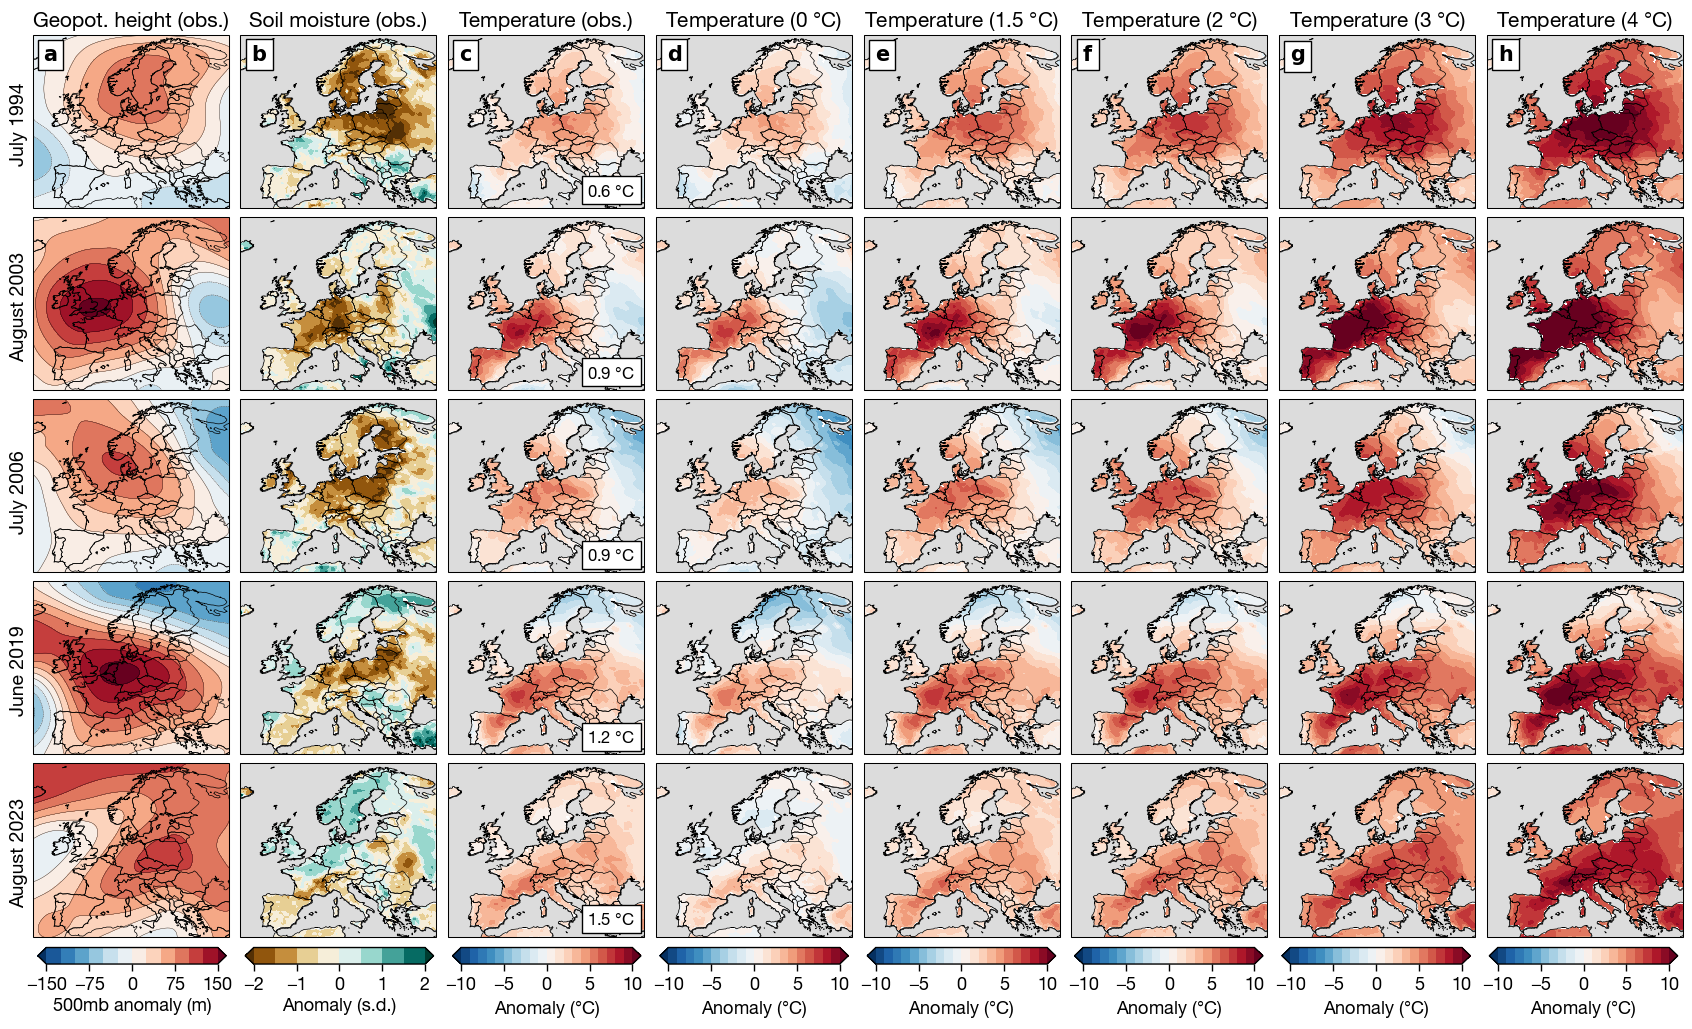

In [8]:
fig = plt.figure(figsize=(20,11))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

tfs = 15
lbfs = 15
cbfs = 13
#lbx = -0.12
#lby = 1.1
lbx = 0.055
lby = 0.85

lbs = [r"$\bf{a}$",r"$\bf{b}$",r"$\bf{c}$",r"$\bf{d}$",r"$\bf{e}$",\
      r"$\bf{f}$",r"$\bf{g}$",r"$\bf{h}$"]

events = ["july_1994","august_2003","july_2006","june_2019","august_2023"]
#event_names = ["August 2003","June 2019","June 2022"]
event_names = [x.split("_")[0].title()+" "+x.split("_")[1] for x in events]

gs0 = gridspec.GridSpec(5,8)
gs0.update(left=0.11,right=0.94,top=0.95,bottom=0.13,wspace=0.01,hspace=0.05)

cbar_axes = gridspec.GridSpec(1,8)
cbar_axes.update(left=0.115,right=0.935,top=0.12,bottom=0.105,wspace=0.1,hspace=0.05)

latmin = 35
latmax = 72
lonmin = 346
lonmax = 33
bds = [lonmin-360,lonmax,latmin,latmax]

## maps of observed meteorology
for x in [0,1,2]:
    for j in np.arange(0,len(events),1):
        ev = events[j]
        event_yr = int(ev.split("_")[1])

        ax = plt.subplot(gs0[j,x],projection=ccrs.Robinson())
        ax.set_extent(bds,crs=ccrs.PlateCarree())
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(0.75)
            spine.set_zorder(11)
        
        ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor="None",zorder=5,linewidth=0.5)
        #ax.add_feature(cart.feature.BORDERS, edgecolor="black",linewidth=0.5,zorder=9,alpha=1)
        
        for i in np.arange(0,len(eu_shp_nuts0.NUTS_ID),1):
            geom = eu_shp_nuts0.loc[eu_shp_nuts0.NUTS_ID==eu_shp_nuts0.NUTS_ID.values[i],"geometry"]
            ax.add_geometries(geom,ccrs.PlateCarree(),facecolor="None",
                            edgecolor="black",linewidth=0.5,zorder=6)
        zmin = -150
        zmax = 150
        zrange = 13
        #zn = 6
        tmin = -10
        tmax = 10
        nrange = 21
        smin = -2
        smax = 2
        srange = 9
        
        #plt.title(event_names[j],fontsize=tfs,pad=8)
    
        if x == 2:
            vals = event_anomalies.temp_anomalies.loc[ev,:,:].load()
            bounds = np.linspace(tmin,tmax,nrange)
            cm = "RdBu_r"
        elif x == 0:
            vals = event_anomalies.hgt_anomalies.loc[ev,:,:].load()
            bounds = np.linspace(zmin,zmax,zrange)
            cm = "RdBu_r"
        elif x == 1:
            vals = event_anomalies.sm_anomalies.loc[ev,:,:].load()
            bounds = np.linspace(smin,smax,srange) 
            cm = "BrBG"

        if (x==0)&(j==0):
            plt.title("Geopot. height (obs.)",fontsize=tfs)
        elif (x==1)&(j==0):
            plt.title("Soil moisture (obs.)",fontsize=tfs)
        elif (x==2)&(j==0):
            plt.title("Temperature (obs.)",fontsize=tfs)
            
        cols = plt.get_cmap(cm)(np.linspace(0,1,len(bounds)+1))
        cmap = colors.ListedColormap(cols[1:-1])
        cmap.set_over(cols[-1])
        cmap.set_under(cols[0])
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap) 
        
        wrap_data, wrap_lon = util.add_cyclic_point(vals,coord=vals.lon)
        cs = ax.contourf(wrap_lon,vals.lat,wrap_data,cmap=cmap,norm=norm,
               transform=ccrs.PlateCarree(),levels=bounds,extend="both",zorder=4)
        if x == 0:
            cs2 = ax.contour(wrap_lon,vals.lat,wrap_data,colors="black",linewidths=0.25,
               transform=ccrs.PlateCarree(),levels=bounds,extend="both",zorder=5)
    
        
        bt = 0.1
        ht = 0.02
        wd = 0.1
        lf = [0.08,0.208,0.334]
        
        if (x == 2)&(j==2):
            lb = r"Anomaly ($\degree$C)"
            tks = [-10,-5,0,5,10]
            ext = "both"
        elif (x==0)&(j==2):
            lb = "500mb anomaly (m)"
            tks = [-150,-75,0,75,150]
            ext = "both"
        elif (x==1)&(j==2):
            lb = "Anomaly (s.d.)"
            tks = [-2,-1,0,1,2]
            ext = "both"

        if j == len(events)-1:
            #cbar_ax = fig.add_axes([lf[x],bt,wd,ht])
            cbar_ax = plt.subplot(cbar_axes[x])
            cb = fig.colorbar(cbar,cax=cbar_ax,norm=norm,orientation="horizontal",
                            extend=ext,drawedges=False,ticks=tks)
            cbar_ax.tick_params(labelsize=cbfs,direction="out",width=1)
            cb.set_label(label=lb,fontsize=cbfs,rotation=0,labelpad=3)
            cb.minorticks_off()

        if x in [1,2]:
            ax.add_feature(cart.feature.OCEAN, edgecolor="black",facecolor="gainsboro", #aliceblue
                           zorder=7,linewidth=0.5)

        if x==0:
            if ev in ["august_2003","august_2023"]:
                ytxt = 0.19
            elif ev == "july_1994":
                ytxt = 0.27
            else:
                ytxt = 0.25
            plt.text(-0.07,ytxt,event_names[j],transform=ax.transAxes,
                     fontsize=14,ha="center",rotation=90)
        
        if j == 0:
            t = plt.text(lbx,lby,lbs[x],fontsize=lbfs,transform=ax.transAxes,zorder=8)
            t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

        if (x==2):
            gmt = np.around(hadcrut.loc[hadcrut.Time==event_yr,"gmt"].values[0],1)
            t = plt.text(0.71,0.07,str(gmt)+r" $\degree$C",fontsize=lbfs-3,transform=ax.transAxes,zorder=8)
            t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))


## maps of temperature under lower or higher GMT
gmts = [0,1.5,2,3,4]
for x in [3,4,5,6,7]:
    for j in np.arange(0,len(events),1):
        g = gmts[x-3]
        ev = events[j]
        #begin = event_anomalies.begindate.loc[ev].values
        #end = event_anomalies.enddate.loc[ev].values
        cf_event = cf_events.counterfactual_events.loc[ev,g,:,:]
        
        ax = plt.subplot(gs0[j,x],projection=ccrs.Robinson())
        ax.set_extent(bds,crs=ccrs.PlateCarree())
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(0.75)
            spine.set_zorder(11)
        
        ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor="None",zorder=5,linewidth=0.5)
        #ax.add_feature(cart.feature.BORDERS, edgecolor="black",linewidth=0.5,zorder=9,alpha=1)
        
        for i in np.arange(0,len(eu_shp_nuts0.NUTS_ID),1):
            geom = eu_shp_nuts0.loc[eu_shp_nuts0.NUTS_ID==eu_shp_nuts0.NUTS_ID.values[i],"geometry"]
            ax.add_geometries(geom,ccrs.PlateCarree(),facecolor="None",
                            edgecolor="black",linewidth=0.5,zorder=6)


        if j == 0:
            plt.title("Temperature ("+str(g)+r" $\degree$C)",fontsize=tfs)

        cm = "RdBu_r"
        cols = plt.get_cmap(cm)(np.linspace(0,1,len(bounds)+1))
        cmap = colors.ListedColormap(cols[1:-1])
        cmap.set_over(cols[-1])
        cmap.set_under(cols[0])
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap) 
        
        wrap_data, wrap_lon = util.add_cyclic_point(cf_event,coord=cf_event.lon)
        cs = ax.contourf(wrap_lon,cf_event.lat,wrap_data,cmap=cmap,norm=norm,
               transform=ccrs.PlateCarree(),levels=bounds,extend="both",zorder=4)
        
        ax.add_feature(cart.feature.OCEAN, edgecolor="black",facecolor="gainsboro", #aliceblue
                           zorder=7,linewidth=0.5)
        
        # colorbar
        bt = 0.1
        ht = 0.02
        wd = 0.1
        lf = [0.46,0.586,0.712,0.838]
        lb = r"Anomaly ($\degree$C)"
        tks = [-10,-5,0,5,10]
        ext = "both"
        if j == len(events)-1:
            #cbar_ax = fig.add_axes([lf[x-3],bt,wd,ht])
            cbar_ax = plt.subplot(cbar_axes[x])
            cb = plt.colorbar(cbar,cax=cbar_ax,norm=norm,orientation="horizontal",
                            extend=ext,drawedges=False,ticks=tks)
            cbar_ax.tick_params(labelsize=cbfs,direction="out",width=1)
            cb.set_label(label=lb,fontsize=cbfs,rotation=0,labelpad=3)
            cb.minorticks_off()

        if j == 0:
            t = plt.text(lbx,lby,lbs[x],fontsize=lbfs,transform=ax.transAxes,zorder=8)
            t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

plt.savefig(loc_figs+"Fig1.pdf") #,dpi=200) #pdf
plt.show()

Now plot the effect of heat on mortality with a model interacted with mean temperature

Get event-specific counterfactuals in nuts regions

In [9]:
events = ["july_1994","august_2003","july_2006","june_2019","august_2023"]
gmts = [0,1.5,2,3,4]
ev_cf = xr.DataArray(np.full((len(events),len(gmts)),np.nan),
                     coords=[events,gmts],dims=["event","gmt"])

wgted_mean = lambda x: sum(x['population'] * x['tmcf']) / sum(x['population'])
for e in np.arange(0,len(events),1):
    ev = events[e]
    print(ev)
    begin = event_definitions.loc[event_definitions.event==ev,"begindate"].values[0]
    end = event_definitions.loc[event_definitions.event==ev,"enddate"].values[0]
    cf_data = pd.read_csv(loc_events+ev+"_EOBSplusCNN_counterfactual_nuts3_daily_tmean.csv",index_col=0)
    cf_data_tm = cf_data.loc[(cf_data.time>=begin)&(cf_data.time<=end),:]
    del(cf_data)
    cf_data_tm_pop = pd.merge(cf_data_tm,weekly_pop_mean,how="left",on="NUTS_ID")
    del(cf_data_tm)
    cf_data_nuts = cf_data_tm_pop.dropna(axis=0,subset="rate").rename(columns={"NUTS_ID":"nuts"})
    #cf_data_nuts = cf_data_tm.loc[[x in panel_nuts for x in cf_data_tm.NUTS_ID.values],:].rename(columns={"NUTS_ID":"nuts"})
    #cf_data_nuts_mean = cf_data_nuts.groupby("gmt").mean(["tmcf"]).reset_index()
    cf_data_nuts_mean = cf_data_nuts.groupby("gmt").apply(wgted_mean,include_groups=False).reset_index().rename(columns={0:"tmcf"})
    ev_cf.loc[ev,:] = cf_data_nuts_mean.loc[[x in gmts for x in cf_data_nuts_mean.gmt.values],:].tmcf.values

july_1994
august_2003
july_2006
june_2019
august_2023


Regression coefficients

In [10]:
age = "total"
nlag = 3
y1 = 2015
y2 = 2019
coefs_eu = pd.read_csv(loc_reg+"europe_weekly_mortality_coefficients_tmean-interact_"+str(nlag)+"lag_"+age+"age_"+str(y1)+"-"+str(y2)+".csv",index_col=0)
tx = np.arange(0,32+0.1,0.1)
nboot = np.amax(coefs_eu.boot.values)
boot = np.arange(1,nboot+1,1)
#terciles #tmean = [5,10,15]
yhat_eu = np.zeros((len(terciles),nboot,len(tx),nlag+1))
for i in np.arange(0,nboot,1):
    coefs_b = coefs_eu.loc[coefs_eu.boot==boot[i],:]
    for l in np.arange(0,nlag+1,1):
        if l==0:
            c1 = coefs_b.loc[coefs_b.term=="tpoly1","estimate"].values[0]
            c2 = coefs_b.loc[coefs_b.term=="tpoly2","estimate"].values[0]
            c3 = coefs_b.loc[coefs_b.term=="tpoly3","estimate"].values[0]
            c4 = coefs_b.loc[coefs_b.term=="tpoly4","estimate"].values[0]
            i1 = coefs_b.loc[coefs_b.term=="tpoly1:tmean","estimate"].values[0]
            i2 = coefs_b.loc[coefs_b.term=="tpoly2:tmean","estimate"].values[0]
            i3 = coefs_b.loc[coefs_b.term=="tpoly3:tmean","estimate"].values[0]
            i4 = coefs_b.loc[coefs_b.term=="tpoly4:tmean","estimate"].values[0]
        else:
            c1 = coefs_b.loc[coefs_b.term=="tpoly1_lag"+str(l),"estimate"].values[0]
            c2 = coefs_b.loc[coefs_b.term=="tpoly2_lag"+str(l),"estimate"].values[0]
            c3 = coefs_b.loc[coefs_b.term=="tpoly3_lag"+str(l),"estimate"].values[0]
            c4 = coefs_b.loc[coefs_b.term=="tpoly4_lag"+str(l),"estimate"].values[0]
            i1 = coefs_b.loc[coefs_b.term=="tmean:tpoly1_lag"+str(l),"estimate"].values[0]
            i2 = coefs_b.loc[coefs_b.term=="tmean:tpoly2_lag"+str(l),"estimate"].values[0]
            i3 = coefs_b.loc[coefs_b.term=="tmean:tpoly3_lag"+str(l),"estimate"].values[0]
            i4 = coefs_b.loc[coefs_b.term=="tmean:tpoly4_lag"+str(l),"estimate"].values[0]
        for tm in np.arange(0,len(terciles),1):
            tmn = terciles[tm]
            yhat_eu[tm,i,:,l] = (tx*(c1+i1*tmn))+((tx**2)*(c2+i2*tmn))+((tx**3)*(c3+i3*tmn))+((tx**4)*(c4+i4*tmn))
yhat_eu_cumulative = np.sum(yhat_eu,axis=3)

In [11]:
print(nboot)

500


Plot!

14.4
17.3
19.700000000000003


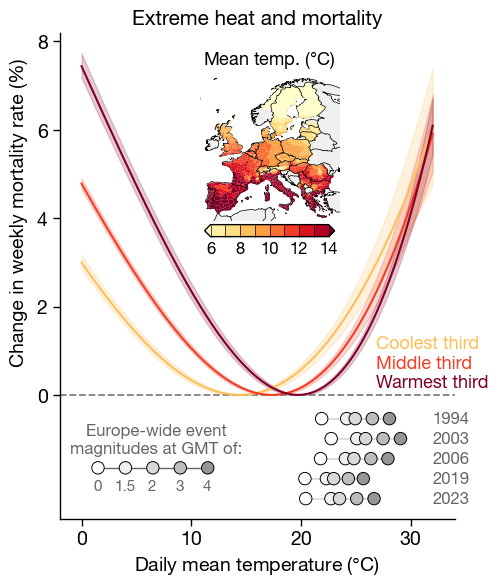

In [12]:
fig = plt.figure(figsize=(5,6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

gs0 = gridspec.GridSpec(1,1)
gs0.update(left=0.11,right=0.9,top=0.92,bottom=0.11,wspace=0.2,hspace=0.2)

tfs = 15
lbfs = 19
lbx = -0.1
lby = 1.06

# colorbar
tmin = 6
tmax = 14
nrange = 9
bounds = np.linspace(tmin,tmax,nrange)
cm = "YlOrRd"
cols = plt.get_cmap(cm)(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap) 

ax = plt.subplot(gs0[0,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.axhline(y=0,color="gray",linewidth=1.3,linestyle="--")

plt.title("Extreme heat and mortality",fontsize=tfs)

for tm in np.arange(0,len(terciles),1):
    yhat_eu_cumulative_plot = yhat_eu_cumulative[tm,:,:]
    ymean = np.mean(yhat_eu_cumulative_plot,axis=0)*100
    ctr_val = tx[np.argmin(ymean)]
    print(ctr_val)
    
    yhat_center = np.zeros(yhat_eu_cumulative_plot.shape)
    for b in np.arange(0,nboot,1):
        yhat_b =  yhat_eu_cumulative_plot[b,:]
        yhat_center[b,:] = yhat_b - yhat_b[np.argmin(yhat_b)]
    ym = np.mean(yhat_center,axis=0)*100
    yl = np.percentile(yhat_center,2.5,axis=0)*100
    yu = np.percentile(yhat_center,97.5,axis=0)*100

    #col = cbar.to_rgba(terciles[tm])
    if tm==0:
        col = cbar.to_rgba(terciles[tm])
        #col = "royalblue"
        plt.text(0.8,0.35,"Coolest third",color=col,
                 fontsize=13,transform=ax.transAxes)
    elif tm == 1:
        col = cbar.to_rgba(terciles[tm])
        #col = "gray"
        plt.text(0.8,0.31,"Middle third",color=col,
                 fontsize=13,transform=ax.transAxes)
    elif tm == 2:
        col = cbar.to_rgba(terciles[tm])
        #col = cbar.to_rgba(terciles[tm])
        plt.text(0.8,0.27,"Warmest third",color=col,
                 fontsize=13,transform=ax.transAxes)
    
    
    ax.fill_between(tx,yl,yu,color=col,alpha=0.2)
    plt.plot(tx,ym,color=col,linewidth=1.5) #,label="Tmean = "+str(tmean[tm]))


#leg = plt.legend(loc="upper center",fontsize=13,frameon=False,handlelength=1.3)
#for legobj in leg.legend_handles:
#    legobj.set_linewidth(2.0)
plt.xlabel(r"Daily mean temperature ($\degree$C)")
plt.ylabel("Change in weekly mortality rate (%)")
ax.yaxis.set_label_coords(-0.08,0.63)



## add space for histograms on the bottom
xl = [np.amin(tx)-2,np.amax(tx)+2]
plt.xlim(xl)
plt.ylim([-2.8,8.2])
plt.yticks([0,2,4,6,8])

gmts = ev_cf.gmt.values #[1.5,2,3,4]
gmt_gray_color = plt.get_cmap('Greys')(np.linspace(0,1,int(len(gmts)*1.8)))

## legend-type thing for bottom inset
textcol = [0.4,0.4,0.4]
plt.text(0.245,0.135,"Europe-wide event\nmagnitudes at GMT of:",
         fontsize=12,rotation=0,ha="center",transform=ax.transAxes,
        color=textcol)

#facecols = [gmt_gray_
#plt.plot([1,3.5,6,8.5,11],[-1.65]*len(gmts),markersize=9,
#         markerfacecolor=[gmt_gray_color[x,:] for x in np.arange(0,len(gmts),1)],
#         color=[0.4,0.4,0.4],marker="o")
xleg = [1.5,4,6.5,9,11.5]
plt.plot(xleg,[-1.65]*len(gmts),color=[0.4,0.4,0.4],linewidth=1,zorder=3)
plt.scatter(xleg,[-1.65]*len(gmts),s=80,
         facecolor=[gmt_gray_color[x,:] for x in np.arange(0,len(gmts),1)],
           edgecolor="black",zorder=4,linewidth=0.7)

for gg in np.arange(0,len(gmts),1):
    g = gmts[gg]
    x = -1.05+(2.5*(gg+1))
    if g==1.5:
        strg = str(g)
    else:
        strg = str(int(g))
    plt.text(x,-2.15,strg,fontsize=11,color=textcol,ha="center")
#plt.text(0,-2.17,"GMT ($\degree$C) = ",fontsize=11,color=textcol)


#bt = [0.32,0.25,0.18,0.11]
# ev_cf # event x gmt x region
inset_ax = fig.add_axes([0.11,0.11,0.79,0.2])
inset_ax.set_xlim(xl)
inset_ax.set_ylim([0,6])
inset_ax.spines["right"].set_visible(False)
inset_ax.spines["top"].set_visible(False)
inset_ax.spines["bottom"].set_visible(False)
inset_ax.spines["left"].set_visible(False)
inset_ax.set_yticks([])
inset_ax.set_xticks([])
inset_ax.patch.set_alpha(0)

yvals = [5,4,3,2,1]
yrs = [x.split("_")[1] for x in events]
for e in events:
    t = ev_cf.loc[e,:]
    ee = list(ev_cf.event.values).index(e)
    #plt.plot(t.values,[yvals[ee]]*len(gmts),marker="o",
    #         markersize=8.5,markeredgewidth=0.5,
    #         linewidth=1.1,markeredgecolor="black",color="lightgray")
    plt.plot(t.values,[yvals[ee]]*len(gmts),color="lightgray",zorder=3,
             linewidth=1.1)
    plt.scatter(t.values,[yvals[ee]]*len(gmts),s=80,
                facecolor=[gmt_gray_color[x,:] for x in np.arange(0,len(gmts),1)],
           edgecolor="black",zorder=4,linewidth=0.7)
    plt.text(32,yvals[ee]-0.25,yrs[ee],fontsize=12,color=textcol)




## regional map

latmin = 34
latmax = 73
lonmin = 349
lonmax = 30
bds = [lonmin-360,lonmax,latmin,latmax]
map_ax = fig.add_axes([0.39,0.57,0.28,0.32],projection=ccrs.Robinson())
map_ax.set_extent(bds,crs=ccrs.PlateCarree())
map_ax.set_title(r"Mean temp. ($\degree$C)",fontsize=13)
for spine in map_ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0)

# features
map_ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor=[0.94,0.94,0.94],
                     zorder=4,linewidth=0.5)
map_ax.add_feature(cart.feature.BORDERS, edgecolor="black",
                     zorder=7,linewidth=0.5)

for i in np.arange(0,len(eu_shp_nuts3.NUTS_ID),1):
    nuts = eu_shp_nuts3.NUTS_ID.values[i]
    geom = eu_shp_nuts3.loc[eu_shp_nuts3.NUTS_ID==nuts,"geometry"]
    nuts_rate = weekly_pop_mean.loc[weekly_pop_mean.NUTS_ID==nuts,"rate"].values
    if (np.nansum(nuts_rate)>0):
        val = panel_clm.loc[panel_clm.nuts==nuts,"tm"].values[0]
        col = cbar.to_rgba(val)
        map_ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                            edgecolor="black",linewidth=0,zorder=6,alpha=1)

for i in np.arange(0,len(eu_shp_nuts1.NUTS_ID),1):
    nuts = eu_shp_nuts1.NUTS_ID.values[i]
    geom = eu_shp_nuts1.loc[eu_shp_nuts1.NUTS_ID==nuts,"geometry"]
    nuts_rate = weekly_pop_mean.loc[weekly_pop_mean.NUTS_ID==nuts,"rate"].values
    if (np.nansum(nuts_rate)>0):
        val = panel_clm.loc[panel_clm.nuts==nuts,"tm"].values[0]
        col = cbar.to_rgba(val)
        map_ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                            edgecolor="black",linewidth=0,zorder=6,alpha=1)

# colorbar
cbar_ax = fig.add_axes([0.4,0.58,0.26,0.02])
cb = fig.colorbar(cbar,cax=cbar_ax,norm=norm,orientation="horizontal",
                  extend="both",drawedges=True,ticks=[6,8,10,12,14])
cbar_ax.tick_params(labelsize=12,width=0,direction="in")
#cb.set_label(label="Mean temp. ($\degree$C)",fontsize=12,rotation=0,labelpad=3)
cb.minorticks_off()


plt.savefig(loc_figs+"Fig2.pdf") #,dpi=250) #.pdf
plt.show()

Mortality from the events

In [32]:
events = ["july_1994","august_2003","july_2006","june_2019","august_2023"]
names = [x.split("_")[0].title()+" "+x.split("_")[1] for x in events]
#names = ["August 2003","June 2019","June 2022"]

july_1994
august_2003
july_2006
june_2019
august_2023


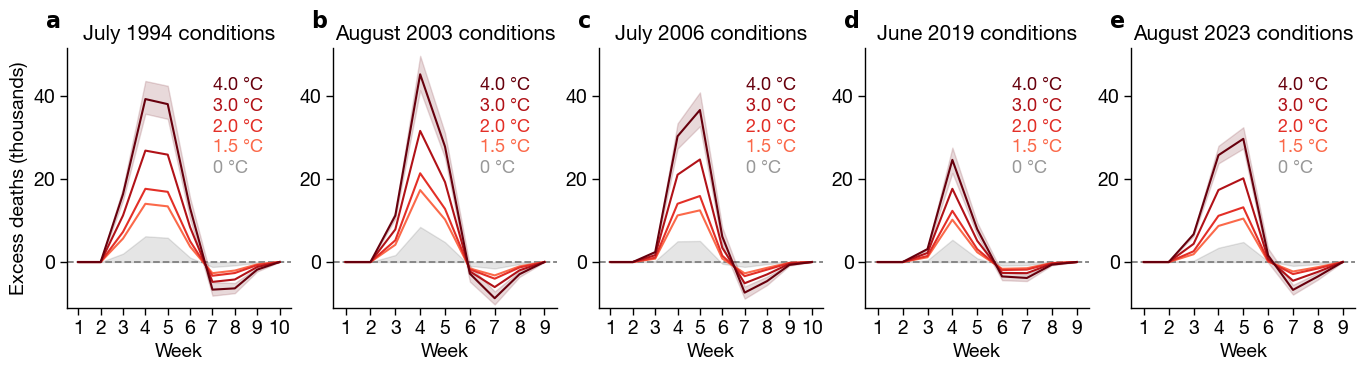

In [33]:
fig = plt.figure(figsize=(14,3.6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"


tfs = 15
lbfs = 16
lbx = -0.1
lby = 1.08

gmts = np.array([0,1.5,2,3,4])
cmap1 = plt.get_cmap('Reds')(np.linspace(0,1,int(len(gmts)*1.5)))
cmap = cmap1[(len(gmts)*-1):,:] #plt.get_cmap('Spectral_r')(np.linspace(0,1,len(gmts)*2))

gs1 = gridspec.GridSpec(1,5)
gs1.update(left=0.05,right=0.97,top=0.88,bottom=0.16,wspace=0.19,hspace=0.2)
lbs0 = [r"$\bf{a}$",r"$\bf{b}$",r"$\bf{c}$",r"$\bf{d}$",r"$\bf{e}$",]

for j in np.arange(0,len(events),1):
    ax = plt.subplot(gs1[0,j])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    plt.axhline(y=0,color="gray",linewidth=1.3,linestyle="--")

    ev = events[j]
    print(ev)
    
    #deaths_in = xr.open_dataset(loc_events+events[j]+"_tmean-interaction_counterfactual_mortality_noadaptation_europewide.nc")
    deaths_in = xr.open_dataset(loc_events+events[j]+"_tmean-interaction_counterfactual_mortality_noadaptation_noeventcf_europewide.nc")
    
    # limit to one week in on the front side
    # to make sure we have full weeks in the daily data
    wks = deaths_in.week.values[1:]
    wk1 = wks[0]
    wk2 = wks[-1]
    
    deaths = deaths_in.deaths.loc[wks,:,:]
    deaths_x_df = deaths.mean(dim="sample").max(dim="week").to_dataframe().reset_index()
    deaths_x_df["event"] = names[j]
    deaths_s_df = deaths.mean(dim="sample").sum(dim="week").to_dataframe().reset_index()
    deaths_s_df["event"] = names[j]

    if j == 0:
        deaths_max_df = deaths_x_df.copy()
        deaths_sum_df = deaths_s_df.copy()
    else:
        deaths_max_df = pd.concat([deaths_max_df,deaths_x_df])
        deaths_sum_df = pd.concat([deaths_sum_df,deaths_s_df])

    # anthropogenic contribution
    deaths_cc = deaths.loc[:,[1.5,2,3,4],:] - deaths.loc[:,0,:]
    deaths_cc_x_df = deaths_cc.mean(dim="sample").max(dim="week").to_dataframe().reset_index()
    deaths_cc_x_df["event"] = names[j]
    deaths_cc_s_df = deaths_cc.mean(dim="sample").sum(dim="week").to_dataframe().reset_index()
    deaths_cc_s_df["event"] = names[j]

    if j == 0:
        deaths_cc_max_df = deaths_cc_x_df.copy()
        deaths_cc_sum_df = deaths_cc_s_df.copy()
    else:
        deaths_cc_max_df = pd.concat([deaths_cc_max_df,deaths_cc_x_df])
        deaths_cc_sum_df = pd.concat([deaths_cc_sum_df,deaths_cc_s_df])

    # plot
    for g in gmts[gmts!=0]:
        col = cmap[list(gmts).index(g)]
        deaths_g = deaths.loc[:,g,:]/1000.0
        deaths_g_mean = deaths_g.mean(dim="sample")
        deaths_g_lower = deaths_g.quantile(q=0.025,dim="sample")
        deaths_g_upper = deaths_g.quantile(q=0.975,dim="sample")
        plt.plot(wks,deaths_g_mean,color=col,linewidth=1.5,
                 label=str(g)+r" $\degree$C",zorder=3)
        if g in [gmts[0],gmts[-1]]:
            ax.fill_between(wks,deaths_g_lower,deaths_g_upper,
                            color=col,alpha=0.15,zorder=2)

        plt.text(0.65,0.52+(0.08*list(gmts).index(g)),str(g)+r" $\degree$C",
                    fontsize=13,color=col,transform=ax.transAxes)

    plt.xticks(ticks=wks,labels=[str(x-wks[0]+1) for x in wks])
    plt.xlabel("Week")
    plt.xlim([wks[0]-0.5,wks[-1]+0.5])
    plt.title(names[j]+" conditions",fontsize=tfs)
    if j == 0:
        plt.ylabel("Excess deaths (thousands)")
    plt.text(lbx,lby,lbs0[j],fontsize=lbfs,transform=ax.transAxes)
    plt.ylim([-11,51.5])

    deaths_0 = deaths.loc[:,0,:]/1000.0
    deaths_0_mean = deaths_0.mean(dim="sample")
    ax.fill_between(wks,deaths_0_mean,color="black",alpha=0.1)
    plt.text(0.65,0.52,r"0 $\degree$C",fontsize=13,color="black",alpha=0.4,
            transform=ax.transAxes)


plt.savefig(loc_figs+"Fig3.pdf")
plt.show()

In [37]:
test = deaths_in.mean(dim="sample").deaths.load()

In [39]:
test[:,4]

<xarray.DataArray 'deaths' (week: 10)> Size: 80B
array([    0.        ,     0.        ,     0.        ,  6686.81763824,
       25764.53955453, 29704.3918914 ,  1594.60739946, -6717.11193764,
       -3489.33809991,     0.        ])
Coordinates:
  * week     (week) int64 80B 29 30 31 32 33 34 35 36 37 38
    gmt      float64 8B 4.0

In [12]:
deaths_sum_df_out = deaths_sum_df.loc[deaths_sum_df.gmt>0,:].copy()
deaths_sum_df_out = pd.merge(deaths_sum_df_out,deaths_max_df.rename(columns={"deaths":"max_deaths"}),how="left",on=["event","gmt"])
deaths_sum_df_out["gmt"] = [x.astype(str) for x in deaths_sum_df_out.gmt.values]
deaths_sum_df_out["max_deaths"] = [int(np.around((x))) for x in deaths_sum_df_out.max_deaths.values]
deaths_sum_df_out["deaths"] = [int(np.around((x))) for x in deaths_sum_df_out.deaths.values]
print(deaths_sum_df_out.loc[:,["event","gmt","max_deaths","deaths"]].to_latex(index=False))

\begin{tabular}{llrr}
\toprule
event & gmt & max_deaths & deaths \\
\midrule
July 1994 & 1.5 & 14038 & 31516 \\
July 1994 & 2.0 & 17652 & 40164 \\
July 1994 & 3.0 & 26865 & 62183 \\
July 1994 & 4.0 & 39295 & 91854 \\
August 2003 & 1.5 & 17340 & 25923 \\
August 2003 & 2.0 & 21401 & 32344 \\
August 2003 & 3.0 & 31620 & 48457 \\
August 2003 & 4.0 & 45266 & 69846 \\
July 2006 & 1.5 & 12463 & 21011 \\
July 2006 & 2.0 & 15917 & 27035 \\
July 2006 & 3.0 & 24721 & 42305 \\
July 2006 & 4.0 & 36658 & 62820 \\
June 2019 & 1.5 & 10200 & 10350 \\
June 2019 & 2.0 & 12346 & 12861 \\
June 2019 & 3.0 & 17657 & 19222 \\
June 2019 & 4.0 & 24635 & 27716 \\
August 2023 & 1.5 & 10475 & 17649 \\
August 2023 & 2.0 & 13191 & 22710 \\
August 2023 & 3.0 & 20183 & 35774 \\
August 2023 & 4.0 & 29704 & 53544 \\
\bottomrule
\end{tabular}



In [13]:
deaths_cc_max_df_out = deaths_max_df.loc[deaths_max_df.gmt>0,:].rename(columns={"deaths":"total_deaths"})
deaths_cc_max_df_out = pd.merge(deaths_cc_max_df_out,deaths_cc_max_df.rename(columns={"deaths":"cc_deaths"}),how="left",on=["event","gmt"])
deaths_cc_max_df_out["gmt"] = [x.astype(str) for x in deaths_cc_max_df_out.gmt.values]
deaths_cc_max_df_out["deaths_percent"] = 100*(deaths_cc_max_df_out.cc_deaths/deaths_cc_max_df_out.total_deaths)
deaths_cc_max_df_out["deaths_percent"] = [str(int(np.around((x))))+r"\%" for x in deaths_cc_max_df_out.deaths_percent.values]
deaths_cc_max_df_out["total_deaths"] = [int(np.around((x))) for x in deaths_cc_max_df_out.total_deaths.values]
deaths_cc_max_df_out["cc_deaths"] = [int(np.around((x))) for x in deaths_cc_max_df_out.cc_deaths.values]
print(deaths_cc_max_df_out.loc[:,["event","gmt","cc_deaths","deaths_percent"]].to_latex(index=False))
#deaths_cc_sum_df_out["gmt"] = [x.astype(str) for x in deaths_cc_sum_df_out.gmt.values]
#deaths_cc_sum_df_out["max_deaths"] = [int(np.around((x))) for x in deaths_cc_sum_df_out.max_deaths.values]
#deaths_cc_sum_df_out["deaths"] = [int(np.around((x))) for x in deaths_cc_sum_df_out.deaths.values]
#print(deaths_cc_sum_df_out.loc[:,["event","gmt","max_deaths","deaths"]].to_latex(index=False))

\begin{tabular}{llrl}
\toprule
event & gmt & cc_deaths & deaths_percent \\
\midrule
July 1994 & 1.5 & 7829 & 56\% \\
July 1994 & 2.0 & 11443 & 65\% \\
July 1994 & 3.0 & 20656 & 77\% \\
July 1994 & 4.0 & 33086 & 84\% \\
August 2003 & 1.5 & 8874 & 51\% \\
August 2003 & 2.0 & 12934 & 60\% \\
August 2003 & 3.0 & 23154 & 73\% \\
August 2003 & 4.0 & 36799 & 81\% \\
July 2006 & 1.5 & 7377 & 59\% \\
July 2006 & 2.0 & 10831 & 68\% \\
July 2006 & 3.0 & 19636 & 79\% \\
July 2006 & 4.0 & 31572 & 86\% \\
June 2019 & 1.5 & 4835 & 47\% \\
June 2019 & 2.0 & 6980 & 57\% \\
June 2019 & 3.0 & 12292 & 70\% \\
June 2019 & 4.0 & 19269 & 78\% \\
August 2023 & 1.5 & 5646 & 54\% \\
August 2023 & 2.0 & 8362 & 63\% \\
August 2023 & 3.0 & 15354 & 76\% \\
August 2023 & 4.0 & 24875 & 84\% \\
\bottomrule
\end{tabular}



In [14]:
deaths_max_df.loc[deaths_max_df.gmt==0,:]

,gmt,deaths,event
0,0.0,6208.812851,July 1994
0,0.0,8466.506893,August 2003
0,0.0,5085.816796,July 2006
0,0.0,5365.811867,June 2019
0,0.0,4829.155928,August 2023


Ballester et al say 11637 was the peak in 2022

In [15]:
deaths_max_df.loc[deaths_max_df.gmt==2,:].deaths/11637 - 1

2    0.516878
2    0.839039
2    0.367786
2    0.060942
2    0.133540
Name: deaths, dtype: float64

In [16]:
deaths_max_df.loc[deaths_max_df.gmt==3,:].deaths/11637 - 1

3    1.308556
3    1.717233
3    1.124378
3    0.517355
3    0.734409
Name: deaths, dtype: float64

Figure 4 - with and without adaptation

In [9]:
events = ["july_1994","august_2003","july_2006","june_2019","august_2023"]
gmt_plot = 3
for j in np.arange(0,len(events),1):
    ev = events[j]
    deaths_noadapt = xr.open_dataset(loc_events+ev+"_tmean-interaction_counterfactual_mortality_noadaptation_noeventcf_europewide.nc")
    deaths_adapt = xr.open_dataset(loc_events+ev+"_tmean-interaction_counterfactual_mortality_scaledadaptation_noeventcf_europewide.nc")
    deaths_noadapt_g = deaths_noadapt.deaths.loc[:,gmt_plot,:]
    deaths_adapt_g = deaths_adapt.deaths.loc[:,gmt_plot,:]
    if j == 0:
        deaths_noadapt_all = deaths_noadapt_g.expand_dims("event")
        deaths_adapt_all = deaths_adapt_g.expand_dims("event")
    else:
        deaths_noadapt_all = xr.concat([deaths_noadapt_all,deaths_noadapt_g],dim="event")
        deaths_adapt_all = xr.concat([deaths_adapt_all,deaths_adapt_g],dim="event")
deaths_noadapt_all.coords["event"] = events
deaths_adapt_all.coords["event"] = events

In [10]:
deaths_noadapt_all.mean(dim="sample").max(dim="week")

<xarray.DataArray 'deaths' (event: 5)> Size: 40B
array([26864.66843101, 31620.44018807, 24721.38756221, 17657.45857485,
       20183.31354238])
Coordinates:
    gmt      float64 8B 3.0
  * event    (event) <U11 220B 'july_1994' 'august_2003' ... 'august_2023'

In [11]:
deaths_adapt_all.mean(dim="sample").max(dim="week")

<xarray.DataArray 'deaths' (event: 5)> Size: 40B
array([23889.31716815, 28091.71859798, 22433.07202724, 15182.35098925,
       17991.52628749])
Coordinates:
    gmt      float64 8B 3.0
  * event    (event) <U11 220B 'july_1994' 'august_2003' ... 'august_2023'

-0.11273625175956589


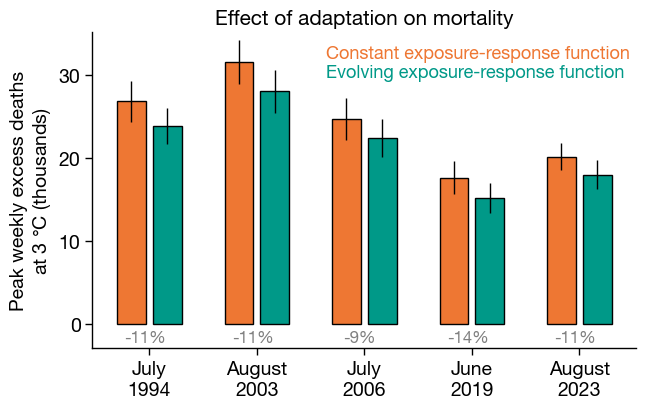

In [13]:
fig = plt.figure(figsize=(6.4,4))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"


## bar plots by event

gs0 = gridspec.GridSpec(1,1)
gs0.update(left=0.13,right=0.98,top=0.92,bottom=0.13,wspace=0.2,hspace=0.2)

tfs = 15
lbfs = 19
lbx = -0.1
lby = 1.06

ax = plt.subplot(gs0[0,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#ax.spines["left"].set_visible(False)

noadapt_col = "#EE7733"
adapt_col = "#009988"

x1 = [0,3,6,9,12]
x2 = [1,4,7,10,13]
tks = [0.5,3.5,6.5,9.5,12.5]

d1 = deaths_noadapt_all.mean(dim="sample").max(dim="week")
d2 = deaths_adapt_all.mean(dim="sample").max(dim="week")
difference = (d2-d1)/d1


plt.bar(x=x1,height=deaths_noadapt_all.mean(dim="sample").max(dim="week")/1000.0,
        edgecolor="black",facecolor=noadapt_col,
       yerr=1.96*deaths_noadapt_all.max(dim="week").std(dim="sample")/1000.0,
       error_kw={"lw":1})
plt.bar(x=x2,height=deaths_adapt_all.mean(dim="sample").max(dim="week")/1000.0,
        edgecolor="black",facecolor=adapt_col,error_kw={"lw":1},
        yerr=1.96*deaths_adapt_all.max(dim="week").std(dim="sample")/1000.0)

#plt.axhline(y=0,color="gray",linestyle="--")

#names = [x.split("_")[0].title()+" "+x.split("_")[1] for x in events]
#plt.xticks(ticks=tks,labels=names,rotation=12,ha="right",rotation_mode="anchor")
names = [x.split("_")[0].title()+"\n"+x.split("_")[1] for x in events]
plt.xticks(ticks=tks,labels=names) #,rotation=12,ha="right",rotation_mode="anchor")


plt.ylim([-3,35.2])
plt.yticks([0,10,20,30])
plt.ylabel("Peak weekly excess deaths"+"\n"+r"at 3 $\degree$C (thousands)")

#lb1 = "Only current adaptations"
#lb2 = "Additional future adaptations"
lb1 = "Constant exposure-response function"
lb2 = "Evolving exposure-response function"
plt.text(0.43,0.92,lb1,color=noadapt_col,fontsize=13,transform=ax.transAxes)
plt.text(0.43,0.86,lb2,color=adapt_col,fontsize=13,transform=ax.transAxes)
plt.title("Effect of adaptation on mortality",fontsize=tfs)

for j in np.arange(0,len(events),1):
    if events[j]=="july_2006":
        xminus = 0.08
    else:
        xminus = 0.2
    plt.text(x1[j]-xminus,-2.2,str(int(np.around(difference.values[j]*100)))+"%",
             fontsize=12,color="gray")
print(difference.mean().values)


plt.savefig(loc_figs+"Fig4.pdf")
plt.show()

COVID comparison

In [20]:
events = ["july_1994","august_2003","july_2006","june_2019","august_2023"]
names = [x.split("_")[0].title()+" "+x.split("_")[1] for x in events]
#names = ["August 2003","June 2019","June 2022"]

In [21]:
map_codes = pd.read_csv(loc_covid+"iso2-to-iso3.csv").loc[:,["name","alpha-2","alpha-3"]]
map_codes = map_codes.rename(columns={"alpha-3":"iso_code","alpha-2":"iso2"})
covid_data_in = pd.read_csv(loc_covid+"owid-covid-data.csv")
covid_data_in["year"] = pd.to_datetime(covid_data_in.date).dt.year
covid_data = covid_data_in.loc[(covid_data_in.year>=2020)&(covid_data_in.year<=2021),:]
covid_data = pd.merge(covid_data,map_codes,how="left",on="iso_code")
colms = ["iso_code","continent","location","iso2","new_deaths"]
covid_data_rolling = covid_data[colms].groupby(["iso_code","continent","location","iso2"]).rolling(7).sum().reset_index()
covid_data_peak = covid_data_rolling.groupby(["iso_code","continent","location","iso2"]).max().reset_index()

[np.float64(0.0), np.float64(141.0)]
[np.float64(141.0), np.float64(1318.0)]
[np.float64(1318.0), np.float64(2156.5)]
[np.float64(2156.5), np.float64(3514.0)]
[np.float64(3514.0), np.float64(5891.0)]
[np.float64(5891.0), np.float64(10639.0)]
[np.float64(10639.0), np.float64(15122.0)]
[np.float64(15122.0), np.float64(18398.0)]
[np.float64(18398.0), np.float64(27923.0)]
[np.float64(27923.0), np.float64(34100.0)]


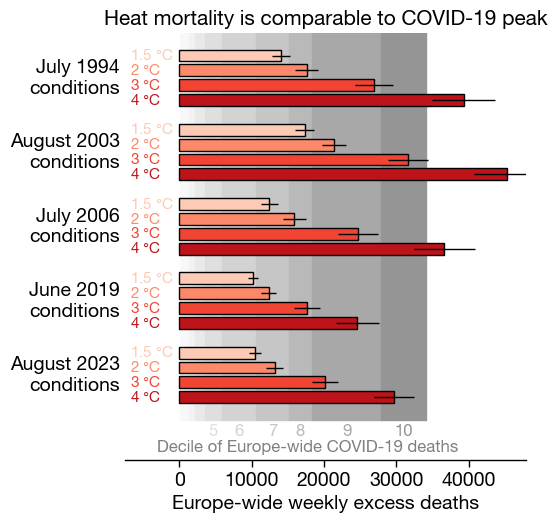

In [24]:
fig = plt.figure(figsize=(5.5,5.2))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

gs0 = gridspec.GridSpec(1,1)
left = 0.22
right = 0.95
bottom = 0.11
gs0.update(left=left,right=right,top=0.93,bottom=bottom,wspace=0.2,hspace=0.2)

tfs = 15
lbfs = 19
lbx = -0.1
lby = 1.06

ax = plt.subplot(gs0[0,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

gmts = [1.5,2,3,4]
cmap1 = plt.get_cmap('Reds')(np.linspace(0,1,int(len(gmts)*1.5)))
#cmap = cmap1[(len(gmts)*-1):,:] #plt.get_cmap('Spectral_r')(np.linspace(0,1,len(gmts)*2))
cmap = cmap1[1:(len(gmts)+1),:]

yvals = np.array([[25,24,23,22],
                [20,19,18,17],
                [15,14,13,12],
                [10,9,8,7],
                 [5,4,3,2]])

for ee in np.arange(0,len(events),1):
    heat_deaths = xr.open_dataset(loc_events+events[ee]+"_tmean-interaction_counterfactual_mortality_noadaptation_noeventcf_europewide.nc")
    for gg in np.arange(0,len(gmts),1):
        g = gmts[gg]
        deaths_g = heat_deaths.deaths.loc[:,g,:] #.stack(uncertainty=("quantile","boot"))
        deaths_g_mean1 = deaths_g.mean(dim="sample")
        deaths_g_max = deaths_g[np.argmax(deaths_g_mean1.values),:]
        deaths_g_mean = deaths_g[np.argmax(deaths_g_mean1.values),:].mean(dim="sample")
        
        deaths_lower = np.percentile(deaths_g_max.values,0.5)
        deaths_upper = np.percentile(deaths_g_max.values,99.5)
        ci = np.percentile(deaths_g_max.values,97.5) - np.mean(deaths_g_max)
        plt.barh(y=yvals[ee,gg],width=deaths_g_mean,xerr=ci,error_kw={"lw":1},
                 facecolor=cmap[gg],edgecolor="black",zorder=4)
        plt.text(-6800,yvals[ee,gg]-0.3,str(g)+r" $\degree$C",fontsize=11,
                 color=cmap[gg])

#sns.despine(ax=ax, offset=0,top=True,right=True,
#            left=True,bottom=False,trim=True)l
lbs = [names[j]+"\nconditions" for j in np.arange(0,len(names),1)]
plt.yticks(ticks=[23.7,18.7,13.7,8.7,3.7],labels=lbs)
           #labels=["1994\nconditions","2003\nconditions","2006\nconditions","2019\nconditions","2023\nconditions"])
ax.tick_params(axis="y",length=0)
#plt.ylim([-4,17])
plt.ylim([-2.2,26.5])
xl = [-7500,48000]
plt.xlim(xl)
plt.title("Heat mortality is comparable to COVID-19 peak",fontsize=tfs)
plt.xlabel("Europe-wide weekly excess deaths")

## covid 
country_deaths_in = xr.open_dataset(loc_events+"august_2003_tmean-interaction_counterfactual_mortality_noadaptation_noeventcf_bycountry.nc")
country_deaths = country_deaths_in.mortality.loc[:,:,1.5,:].mean(dim=["week","sample"])
country_deaths_nonzero = country_deaths[country_deaths!=0]
countries_include = np.concatenate([country_deaths_nonzero.country.values,["GB","GR"]])

covid_data_subset = covid_data.loc[[x in countries_include for x in covid_data.iso2.values],:]
covid_data_total = covid_data_subset[["date","year","new_deaths"]].groupby(["date","year"]).sum().reset_index()
covid_data_total_running = covid_data_total["new_deaths"].rolling(7).sum().reset_index()
covid_data_total["week"] = pd.to_datetime(covid_data_total.date).dt.isocalendar().week
covid_data_total_wk = covid_data_total.drop(columns="date").groupby(["year","week"]).sum().reset_index()
covid_data_vec = covid_data_total_wk.new_deaths.values
covid_pctiles = np.percentile(covid_data_vec,np.arange(0,110,10))
covid_cmap = plt.get_cmap('Greys')(np.linspace(0,1,int(len(covid_pctiles)*1.8)))

for pp in np.arange(0,len(covid_pctiles)-1,1):
    p1 = covid_pctiles[pp]
    p2 = covid_pctiles[pp+1]
    col = covid_cmap[pp]
    print([p1,p2])
    ax.fill_between([p1,p2],0.5,27,color=col,alpha=1,zorder=1)
    if pp>3:
        halfway = (p2-p1)/2
        plt.text(p1+halfway,-0.6,str(pp+1),color=col,fontsize=12,ha="center")
plt.text(0.08,0.018,"Decile of Europe-wide COVID-19 deaths",
            fontsize=12,color="gray",transform=ax.transAxes)


plt.savefig(loc_figs+"FigX_COVID.pdf")
plt.show()

Supplementary figure -- maps

In [13]:
events = ["july_1994","august_2003","july_2006","june_2019","august_2023"]
names = [x.split("_")[0].title()+" "+x.split("_")[1] for x in events]
#names = ["August 2003","June 2019","June 2022"]

-0.7169070513676923
14.460288650732451
-0.04646835163317074
25.768548168076833
-0.13829592284558298
12.434186903413345
0.002184097218222884
10.612586451694536
-0.09128560503750859
17.169453820407156


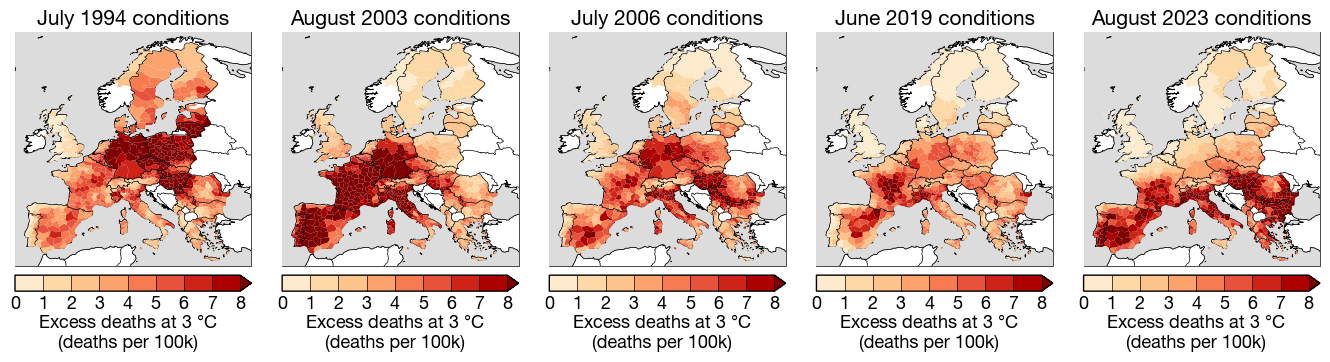

In [16]:
fig = plt.figure(figsize=(15,4))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

tfs = 15
lbfs = 19
lbx = -0.1
lby = 1.06
#gmts = [1.5,2,3,4]
#cmap1 = plt.get_cmap('Reds')(np.linspace(0,1,int(len(gmts)*1.5)))
#cmap = cmap1[(len(gmts)*-1):,:] #plt.get_cmap('Spectral_r')(np.linspace(0,1,len(gmts)*2))

## maps
gs1 = gridspec.GridSpec(1,5)
gs1.update(left=0.08,right=0.95,top=0.9,bottom=0.2,wspace=0.13,hspace=0.2)
cbar_axes = gridspec.GridSpec(1,5)
cbar_axes.update(left=0.08,right=0.95,top=0.235,bottom=0.195,wspace=0.13,hspace=0.05)

for j in np.arange(0,len(events),1):

    ## country-level data
    deaths_in = xr.open_dataset(loc_events+events[j]+"_tmean-interaction_counterfactual_mortality_noadaptation_noeventcf_byregion.nc")
    gmt_example = 3
    # europe-wide -- for peak week
    deaths_eu = xr.open_dataset(loc_events+events[j]+"_tmean-interaction_counterfactual_mortality_noadaptation_noeventcf_europewide.nc")
    wks = deaths_eu.week.values
    deaths_eu_g = deaths_eu.deaths.loc[:,gmt_example,:].mean(dim=["sample"])
    peak_wk = wks[np.argmax(deaths_eu_g.values)]
    del([deaths_eu,deaths_eu_g])
        
    region_deaths = deaths_in.mortality.loc[:,peak_wk,gmt_example] #.mean(dim="boot")
    region_population = deaths_in.population.load()
    region_rate_wk = region_deaths/(region_population/1e5)
    print(np.nanmin(region_rate_wk))
    print(np.nanmax(region_rate_wk))

    
    ## plot
    ax = plt.subplot(gs1[0,j],projection=ccrs.Robinson())
    latmin = 34
    latmax = 72
    lonmin = 349
    lonmax = 32
    bds = [lonmin-360,lonmax,latmin,latmax]
    #map_ax = fig.add_axes([0.38,0.62,0.3,0.3],projection=ccrs.Robinson())
    ax.set_extent(bds,crs=ccrs.PlateCarree())
    
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
    
    ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor="None",
                         zorder=5,linewidth=0.5)
    ax.add_feature(cart.feature.OCEAN, edgecolor="black",facecolor="gainsboro", #aliceblue
                           zorder=7,linewidth=0.5)
    
    # colorbar
    maxs = [5,5,4,3,4]
    nranges = [11,11,9,7,9]
    cmin = 0 #maxs[j]*-1
    cmax = 8 #maxs[j]
    nrange = 9 #nranges[j]
    bounds = np.linspace(cmin,cmax,nrange)
    cols = plt.get_cmap("OrRd")(np.linspace(0,1,len(bounds)+1))
    cmap = colors.ListedColormap(cols[1:-1])
    cmap.set_over(cols[-1])
    cmap.set_under(cols[0])
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
    cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap) 

    ax.add_feature(cart.feature.BORDERS, edgecolor="black",
                     zorder=9,linewidth=0.5)
    
    for i in np.arange(0,len(eu_shp_nuts3.NUTS_ID),1):
        nuts = eu_shp_nuts3.NUTS_ID.values[i]
        geom = eu_shp_nuts3.loc[eu_shp_nuts3.NUTS_ID==nuts,"geometry"]
        if nuts in region_rate_wk.nuts.values:
            val = region_rate_wk.loc[nuts].values
            if (val!=0)&(~np.isnan(val)):
                col = cbar.to_rgba(val)
                ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                 edgecolor="black",linewidth=0,zorder=8,alpha=1)
        #    else:
        #        ax.add_geometries(geom,ccrs.PlateCarree(),facecolor="yellow",
        #                         edgecolor="black",linewidth=0,zorder=8,alpha=1)
        #else:
        #    ax.add_geometries(geom,ccrs.PlateCarree(),facecolor="green",
        #                         edgecolor="black",linewidth=0,zorder=8,alpha=1)
    
    for i in np.arange(0,len(eu_shp_nuts1.NUTS_ID),1):
        nuts = eu_shp_nuts1.NUTS_ID.values[i]
        geom = eu_shp_nuts1.loc[eu_shp_nuts1.NUTS_ID==nuts,"geometry"]
        if nuts in region_rate_wk.nuts.values:
            val = region_rate_wk.loc[nuts].values
            if (val!=0)&(~np.isnan(val)):
                col = cbar.to_rgba(val)
                ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                 edgecolor="black",linewidth=0,zorder=8,alpha=1)
    
    plt.title(names[j]+" conditions",fontsize=tfs,pad=5)
    
    # colorbar across bottom
    
    #lefts = [0.155,0.397,0.64]
    #cbar_ax = fig.add_axes([lefts[j],0.07,0.205,0.02])
    cbar_ax = plt.subplot(cbar_axes[j])
    cb = fig.colorbar(cbar,cax=cbar_ax,norm=norm,orientation="horizontal",
                    extend="max",drawedges=True,ticks=np.arange(cmin,cmax+1,1))
    cbar_ax.tick_params(labelsize=13,direction="in",width=0)
    cb.set_label(label=r"Excess deaths at 3 $\degree$C"+"\n(deaths per 100k)",
                 fontsize=13,rotation=0,labelpad=1)
    cb.minorticks_off()

plt.savefig(loc_figs+"FigX_RegionMaps.png",dpi=250)
plt.show()

Effects across lags

[ 5.99777743  0.49408996 -1.51566742 -0.82238396]
4.1538160161704045
[ 5.20260065  0.84235899 -1.13243644 -0.78307391]
4.129449289851904
[ 4.18097097  1.28980916 -0.64006777 -0.73256902]
4.098143331900562
[ 6.02051785  0.60648302 -1.29259191 -0.85322814 -0.09292376 -0.7932331
 -1.11917793]
2.4758460385110235
[ 5.20851937  0.9277187  -0.9986625  -0.75792284 -0.23915676 -0.596375
 -0.7635588 ]
2.7805621540790435
[ 4.16527744  1.34043688 -0.62102697 -0.63547622 -0.42703446 -0.34345505
 -0.30666536]
3.172056266844865


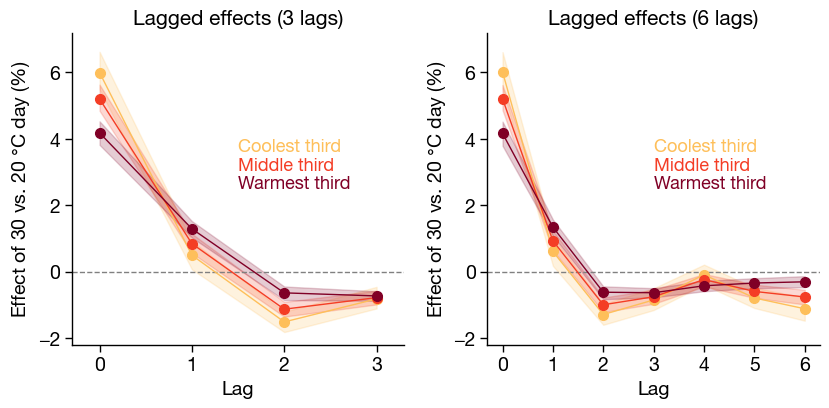

In [35]:
fig = plt.figure(figsize=(8.5,4))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

tfs = 15
lbfs = 16
lbx = -0.09
lby = 1.08

# colorbar
tmin = 6
tmax = 14
nrange = 9
bounds = np.linspace(tmin,tmax,nrange)
cm = "YlOrRd"
cols = plt.get_cmap(cm)(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap) 

# temps
t1 = 20
t2 = 30

# lags to plot
lags_plot = [3,6]

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.09,right=0.97,top=0.92,bottom=0.14,wspace=0.25,hspace=0.2)

for j in [0,1]:
    ax = plt.subplot(gs1[0,j])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    nlag = lags_plot[j]
    lags = np.arange(0,nlag+1,1)

    # read regression output
    age = "total"
    y1 = 2015
    y2 = 2019
    coefs_eu = pd.read_csv(loc_reg+"europe_weekly_mortality_coefficients_tmean-interact_"+str(nlag)+"lag_"+age+"age_"+str(y1)+"-"+str(y2)+".csv",index_col=0)
    tx = np.arange(0,32+0.1,0.1)
    nboot = np.amax(coefs_eu.boot.values)
    boot = np.arange(1,nboot+1,1)
    yhat_eu = np.zeros((len(terciles),nboot,len(tx),nlag+1))
    for i in np.arange(0,nboot,1):
        coefs_b = coefs_eu.loc[coefs_eu.boot==boot[i],:]
        for l in np.arange(0,nlag+1,1):
            if l==0:
                c1 = coefs_b.loc[coefs_b.term=="tpoly1","estimate"].values[0]
                c2 = coefs_b.loc[coefs_b.term=="tpoly2","estimate"].values[0]
                c3 = coefs_b.loc[coefs_b.term=="tpoly3","estimate"].values[0]
                c4 = coefs_b.loc[coefs_b.term=="tpoly4","estimate"].values[0]
                i1 = coefs_b.loc[coefs_b.term=="tpoly1:tmean","estimate"].values[0]
                i2 = coefs_b.loc[coefs_b.term=="tpoly2:tmean","estimate"].values[0]
                i3 = coefs_b.loc[coefs_b.term=="tpoly3:tmean","estimate"].values[0]
                i4 = coefs_b.loc[coefs_b.term=="tpoly4:tmean","estimate"].values[0]
            else:
                c1 = coefs_b.loc[coefs_b.term=="tpoly1_lag"+str(l),"estimate"].values[0]
                c2 = coefs_b.loc[coefs_b.term=="tpoly2_lag"+str(l),"estimate"].values[0]
                c3 = coefs_b.loc[coefs_b.term=="tpoly3_lag"+str(l),"estimate"].values[0]
                c4 = coefs_b.loc[coefs_b.term=="tpoly4_lag"+str(l),"estimate"].values[0]
                i1 = coefs_b.loc[coefs_b.term=="tmean:tpoly1_lag"+str(l),"estimate"].values[0]
                i2 = coefs_b.loc[coefs_b.term=="tmean:tpoly2_lag"+str(l),"estimate"].values[0]
                i3 = coefs_b.loc[coefs_b.term=="tmean:tpoly3_lag"+str(l),"estimate"].values[0]
                i4 = coefs_b.loc[coefs_b.term=="tmean:tpoly4_lag"+str(l),"estimate"].values[0]
            for tm in np.arange(0,len(terciles),1):
                tmn = terciles[tm]
                yhat_eu[tm,i,:,l] = (tx*(c1+i1*tmn))+((tx**2)*(c2+i2*tmn))+((tx**3)*(c3+i3*tmn))+((tx**4)*(c4+i4*tmn))
    yhat_eu_lags_plot = yhat_eu[:,:,tx==t2,:] - yhat_eu[:,:,tx==t1,:]
    
    # plot
    plt.axhline(y=0,color="gray",linewidth=1,linestyle="--")
    
    for tt in np.arange(0,len(terciles),1):
        yhat_eu_lags_t = np.squeeze(yhat_eu_lags_plot[tt,:,:,:])*100
        col = cbar.to_rgba(terciles[tt])
        y_lags_mean = np.mean(yhat_eu_lags_t,axis=0)
        y_lags_lower = np.percentile(yhat_eu_lags_t,2.5,axis=0)
        y_lags_upper = np.percentile(yhat_eu_lags_t,97.5,axis=0)
        print(y_lags_mean) 
        print(np.sum(y_lags_mean))
        ax.fill_between(lags,y_lags_lower,y_lags_upper,color=col,alpha=0.2)
        plt.plot(lags,y_lags_mean,markersize=7,markerfacecolor=col,markeredgecolor=None,
                color=col,linewidth=1,marker="o")
        if tt==0:
            plt.text(0.5,0.62,"Coolest third",color=col,
                     fontsize=13,transform=ax.transAxes)
        elif tt == 1:
            plt.text(0.5,0.56,"Middle third",color=col,
                     fontsize=13,transform=ax.transAxes)
        elif tt == 2:
            plt.text(0.5,0.5,"Warmest third",color=col,
                     fontsize=13,transform=ax.transAxes)
    plt.title("Lagged effects ("+str(nlag)+" lags)",fontsize=tfs)
    
    plt.xticks(lags)
    plt.xlabel("Lag")
    plt.ylabel("Effect of "+str(t2)+" vs. "+str(t1)+" $\degree$C day (%)")
    plt.ylim([-2.2,7.2])
    plt.xlim([-0.3,nlag+0.3])

plt.savefig(loc_figs+"FigX_More_Lags.pdf")
plt.show()

500
500
500


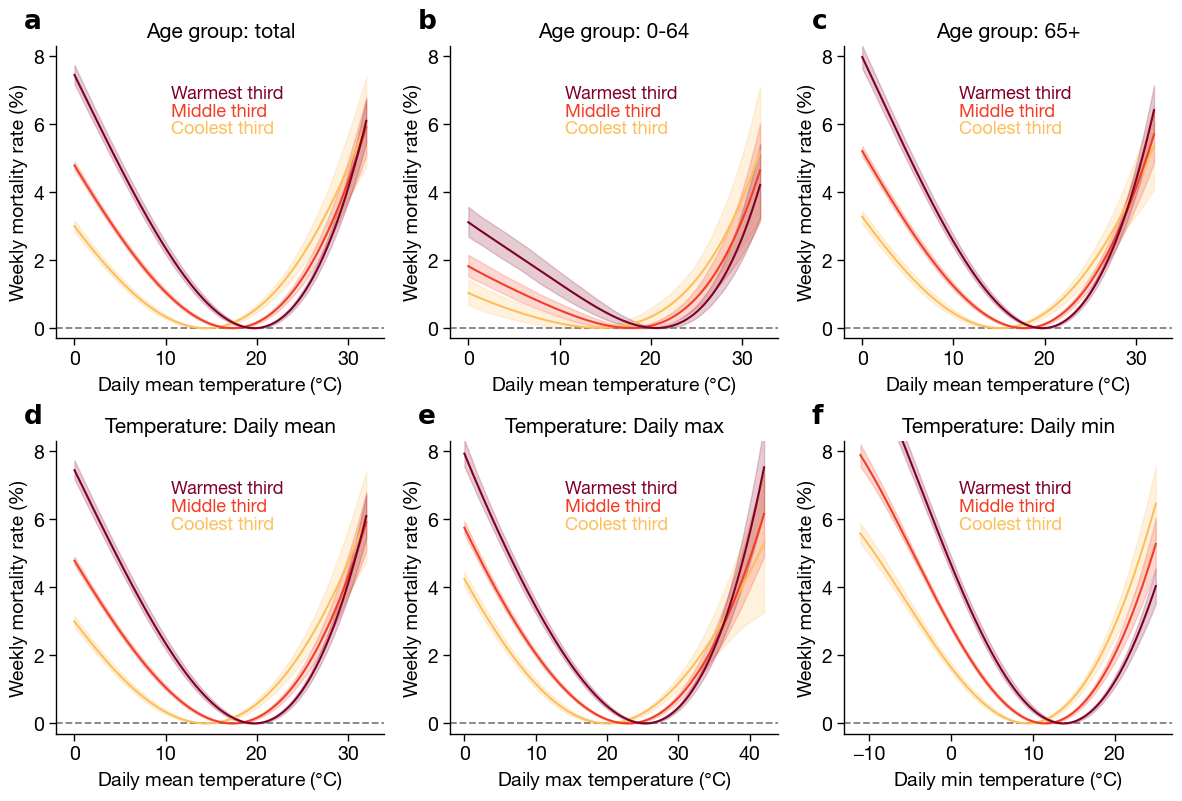

In [12]:
fig = plt.figure(figsize=(12,8))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

gs0 = gridspec.GridSpec(2,3)
gs0.update(left=0.05,right=0.98,top=0.94,bottom=0.08,wspace=0.2,hspace=0.35)

tfs = 15
lbfs = 19
lbx = -0.1
lby = 1.06

lbs0 = [r"$\bf{a}$",r"$\bf{b}$",r"$\bf{c}$"]
lbs1 = [r"$\bf{d}$",r"$\bf{e}$",r"$\bf{f}$"]


# colorbar
tmin = 6
tmax = 14
nrange = 9
bounds = np.linspace(tmin,tmax,nrange)
cm = "YlOrRd"
cols = plt.get_cmap(cm)(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap) 

ages = ["total","0-64","65+"]

for j in [0,1,2]:
    ax = plt.subplot(gs0[0,j])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    plt.axhline(y=0,color="gray",linewidth=1.3,linestyle="--")
    
    age = ages[j] #total"
    nlag = 3
    y1 = 2015
    y2 = 2019
    coefs_eu = pd.read_csv(loc_reg+"europe_weekly_mortality_coefficients_tmean-interact_"+str(nlag)+"lag_"+age+"age_"+str(y1)+"-"+str(y2)+".csv",index_col=0)
    tx = np.arange(0,32+0.1,0.1)
    nboot = np.amax(coefs_eu.boot.values)
    boot = np.arange(1,nboot+1,1)
    #terciles #tmean = [5,10,15]
    yhat_eu = np.zeros((len(terciles),nboot,len(tx),nlag+1))
    for i in np.arange(0,nboot,1):
        coefs_b = coefs_eu.loc[coefs_eu.boot==boot[i],:]
        for l in np.arange(0,nlag+1,1):
            if l==0:
                c1 = coefs_b.loc[coefs_b.term=="tpoly1","estimate"].values[0]
                c2 = coefs_b.loc[coefs_b.term=="tpoly2","estimate"].values[0]
                c3 = coefs_b.loc[coefs_b.term=="tpoly3","estimate"].values[0]
                c4 = coefs_b.loc[coefs_b.term=="tpoly4","estimate"].values[0]
                i1 = coefs_b.loc[coefs_b.term=="tpoly1:tmean","estimate"].values[0]
                i2 = coefs_b.loc[coefs_b.term=="tpoly2:tmean","estimate"].values[0]
                i3 = coefs_b.loc[coefs_b.term=="tpoly3:tmean","estimate"].values[0]
                i4 = coefs_b.loc[coefs_b.term=="tpoly4:tmean","estimate"].values[0]
            else:
                c1 = coefs_b.loc[coefs_b.term=="tpoly1_lag"+str(l),"estimate"].values[0]
                c2 = coefs_b.loc[coefs_b.term=="tpoly2_lag"+str(l),"estimate"].values[0]
                c3 = coefs_b.loc[coefs_b.term=="tpoly3_lag"+str(l),"estimate"].values[0]
                c4 = coefs_b.loc[coefs_b.term=="tpoly4_lag"+str(l),"estimate"].values[0]
                i1 = coefs_b.loc[coefs_b.term=="tmean:tpoly1_lag"+str(l),"estimate"].values[0]
                i2 = coefs_b.loc[coefs_b.term=="tmean:tpoly2_lag"+str(l),"estimate"].values[0]
                i3 = coefs_b.loc[coefs_b.term=="tmean:tpoly3_lag"+str(l),"estimate"].values[0]
                i4 = coefs_b.loc[coefs_b.term=="tmean:tpoly4_lag"+str(l),"estimate"].values[0]
            for tm in np.arange(0,len(terciles),1):
                tmn = terciles[tm]
                yhat_eu[tm,i,:,l] = (tx*(c1+i1*tmn))+((tx**2)*(c2+i2*tmn))+((tx**3)*(c3+i3*tmn))+((tx**4)*(c4+i4*tmn))
    yhat_eu_cumulative = np.sum(yhat_eu,axis=3)
    #print(np.mean(yhat_eu_cumulative[2,:,30]))
    
    for tm in np.arange(0,len(terciles),1):
        yhat_eu_cumulative_plot = yhat_eu_cumulative[tm,:,:]

        yhat_center = np.zeros(yhat_eu_cumulative_plot.shape)
        for b in np.arange(0,nboot,1):
            yhat_b =  yhat_eu_cumulative_plot[b,:]
            yhat_center[b,:] = yhat_b - yhat_b[np.argmin(yhat_b)]
        ym = np.mean(yhat_center,axis=0)*100
        yl = np.percentile(yhat_center,2.5,axis=0)*100
        yu = np.percentile(yhat_center,97.5,axis=0)*100

        """
        ymean = np.mean(yhat_eu_cumulative_plot,axis=0)*100
        ctr_val = tx[np.argmin(ymean)]
        if age=="total":
           print(ctr_val)
        ym = ymean - ymean[tx==ctr_val]
        print(ym[tx==30]-ym[tx==20])
        ylower = np.percentile(yhat_eu_cumulative_plot,2.5,axis=0)*100
        yupper = np.percentile(yhat_eu_cumulative_plot,97.5,axis=0)*100
        
        yl = ylower - ylower[tx==ctr_val]
        yu = yupper - yupper[tx==ctr_val]
        """
        
        #col = cbar.to_rgba(terciles[tm])
        if tm==0:
            col = cbar.to_rgba(terciles[tm])
            #col = "royalblue"
            plt.text(0.35,0.7,"Coolest third",color=col,
                     fontsize=13,transform=ax.transAxes)
        elif tm == 1:
            col = cbar.to_rgba(terciles[tm])
            #col = "gray"
            plt.text(0.35,0.76,"Middle third",color=col,
                     fontsize=13,transform=ax.transAxes)
        elif tm == 2:
            col = cbar.to_rgba(terciles[tm])
            #col = cbar.to_rgba(terciles[tm])
            plt.text(0.35,0.82,"Warmest third",color=col,
                     fontsize=13,transform=ax.transAxes)
        
        
        ax.fill_between(tx,yl,yu,color=col,alpha=0.2)
        plt.plot(tx,ym,color=col,linewidth=1.5) #,label="Tmean = "+str(tmean[tm]))
    
    
    #leg = plt.legend(loc="upper center",fontsize=13,frameon=False,handlelength=1.3)
    #for legobj in leg.legend_handles:
    #    legobj.set_linewidth(2.0)
    plt.xlabel(r"Daily mean temperature ($\degree$C)")
    plt.ylabel("Weekly mortality rate (%)")
    
    xl = [np.amin(tx)-2,np.amax(tx)+2]
    plt.xlim(xl)
    plt.ylim([-0.3,8.3])
    plt.yticks([0,2,4,6,8])
    plt.title("Age group: "+ages[j],fontsize=tfs)
    plt.text(lbx,lby,lbs0[j],fontsize=lbfs,transform=ax.transAxes)
    

vars = ["t","tx","tn"]
vnames = ["Daily mean","Daily max","Daily min"]
for j in [0,1,2]:
    v = vars[j]
    ax = plt.subplot(gs0[1,j])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.title("Temperature: "+vnames[j],fontsize=tfs)
    
    plt.axhline(y=0,color="gray",linewidth=1.3,linestyle="--")
    
    age = "total" #ages[j] #total"
    nlag = 3
    y1 = 2015
    y2 = 2019
    if v=="t":
        coefs_eu = pd.read_csv(loc_reg+"europe_weekly_mortality_coefficients_tmean-interact_"+str(nlag)+"lag_"+age+"age_"+str(y1)+"-"+str(y2)+".csv",index_col=0)
    else:
        coefs_eu = pd.read_csv(loc_reg+"europe_weekly_mortality_coefficients_tmean-interact_"+v+"_"+str(nlag)+"lag_"+age+"age_"+str(y1)+"-"+str(y2)+".csv",index_col=0)
    if v == "t":
        tx = np.arange(0,32+0.1,0.1)
    elif v == "tx":
        tx = np.arange(0,42+0.1,0.1)
    elif v == "tn":
        tx = np.arange(-11,25+0.1,0.1)
    nboot = np.amax(coefs_eu.boot.values)
    print(nboot)
    boot = np.arange(1,nboot+1,1)
    #terciles #tmean = [5,10,15]
    yhat_eu = np.zeros((len(terciles),nboot,len(tx),nlag+1))
    for i in np.arange(0,nboot,1):
        coefs_b = coefs_eu.loc[coefs_eu.boot==boot[i],:]
        for l in np.arange(0,nlag+1,1):
            if l==0:
                c1 = coefs_b.loc[coefs_b.term==v+"poly1","estimate"].values[0]
                c2 = coefs_b.loc[coefs_b.term==v+"poly2","estimate"].values[0]
                c3 = coefs_b.loc[coefs_b.term==v+"poly3","estimate"].values[0]
                c4 = coefs_b.loc[coefs_b.term==v+"poly4","estimate"].values[0]
                i1 = coefs_b.loc[coefs_b.term==v+"poly1:tmean","estimate"].values[0]
                i2 = coefs_b.loc[coefs_b.term==v+"poly2:tmean","estimate"].values[0]
                i3 = coefs_b.loc[coefs_b.term==v+"poly3:tmean","estimate"].values[0]
                i4 = coefs_b.loc[coefs_b.term==v+"poly4:tmean","estimate"].values[0]
            else:
                c1 = coefs_b.loc[coefs_b.term==v+"poly1_lag"+str(l),"estimate"].values[0]
                c2 = coefs_b.loc[coefs_b.term==v+"poly2_lag"+str(l),"estimate"].values[0]
                c3 = coefs_b.loc[coefs_b.term==v+"poly3_lag"+str(l),"estimate"].values[0]
                c4 = coefs_b.loc[coefs_b.term==v+"poly4_lag"+str(l),"estimate"].values[0]
                i1 = coefs_b.loc[coefs_b.term=="tmean:"+v+"poly1_lag"+str(l),"estimate"].values[0]
                i2 = coefs_b.loc[coefs_b.term=="tmean:"+v+"poly2_lag"+str(l),"estimate"].values[0]
                i3 = coefs_b.loc[coefs_b.term=="tmean:"+v+"poly3_lag"+str(l),"estimate"].values[0]
                i4 = coefs_b.loc[coefs_b.term=="tmean:"+v+"poly4_lag"+str(l),"estimate"].values[0]
            for tm in np.arange(0,len(terciles),1):
                tmn = terciles[tm]
                yhat_eu[tm,i,:,l] = (tx*(c1+i1*tmn))+((tx**2)*(c2+i2*tmn))+((tx**3)*(c3+i3*tmn))+((tx**4)*(c4+i4*tmn))
    yhat_eu_cumulative = np.sum(yhat_eu,axis=3)
    #print(np.mean(yhat_eu_cumulative[2,:,30]))
    
    for tm in np.arange(0,len(terciles),1):
        yhat_eu_cumulative_plot = yhat_eu_cumulative[tm,:,:]

        yhat_center = np.zeros(yhat_eu_cumulative_plot.shape)
        for b in np.arange(0,nboot,1):
            yhat_b =  yhat_eu_cumulative_plot[b,:]
            yhat_center[b,:] = yhat_b - yhat_b[np.argmin(yhat_b)]
        ym = np.mean(yhat_center,axis=0)*100
        yl = np.percentile(yhat_center,2.5,axis=0)*100
        yu = np.percentile(yhat_center,97.5,axis=0)*100


        #ymean = np.mean(yhat_eu_cumulative_plot,axis=0)*100
        #ctr_val = tx[np.argmin(ymean)]
        #ym = ymean - ymean[tx==ctr_val]
        #ylower = np.percentile(yhat_eu_cumulative_plot,2.5,axis=0)*100
        #yupper = np.percentile(yhat_eu_cumulative_plot,97.5,axis=0)*100
        
        #yl = ylower - ylower[tx==ctr_val]
        #yu = yupper - yupper[tx==ctr_val]
    
        #col = cbar.to_rgba(terciles[tm])
        if tm==0:
            col = cbar.to_rgba(terciles[tm])
            #col = "royalblue"
            plt.text(0.35,0.7,"Coolest third",color=col,
                     fontsize=13,transform=ax.transAxes)
        elif tm == 1:
            col = cbar.to_rgba(terciles[tm])
            #col = "gray"
            plt.text(0.35,0.76,"Middle third",color=col,
                     fontsize=13,transform=ax.transAxes)
        elif tm == 2:
            col = cbar.to_rgba(terciles[tm])
            #col = cbar.to_rgba(terciles[tm])
            plt.text(0.35,0.82,"Warmest third",color=col,
                     fontsize=13,transform=ax.transAxes)
        
        
        ax.fill_between(tx,yl,yu,color=col,alpha=0.2)
        plt.plot(tx,ym,color=col,linewidth=1.5) #,label="Tmean = "+str(tmean[tm]))
    
    
    #leg = plt.legend(loc="upper center",fontsize=13,frameon=False,handlelength=1.3)
    #for legobj in leg.legend_handles:
    #    legobj.set_linewidth(2.0)
    plt.xlabel(vnames[j]+r" temperature ($\degree$C)")
    plt.ylabel("Weekly mortality rate (%)")
    
    xl = [np.amin(tx)-2,np.amax(tx)+2]
    plt.xlim(xl)
    plt.ylim([-0.3,8.3])
    plt.yticks([0,2,4,6,8])
    plt.text(lbx,lby,lbs1[j],fontsize=lbfs,transform=ax.transAxes)
    

plt.savefig(loc_figs+"FigX_Ages_MaxMin.pdf")
plt.show()

Plot daily temps during the event

In [7]:
events = ["july_1994","august_2003","july_2006","june_2019","august_2023"]
names = [x.split("_")[0].title()+" "+x.split("_")[1] for x in events]

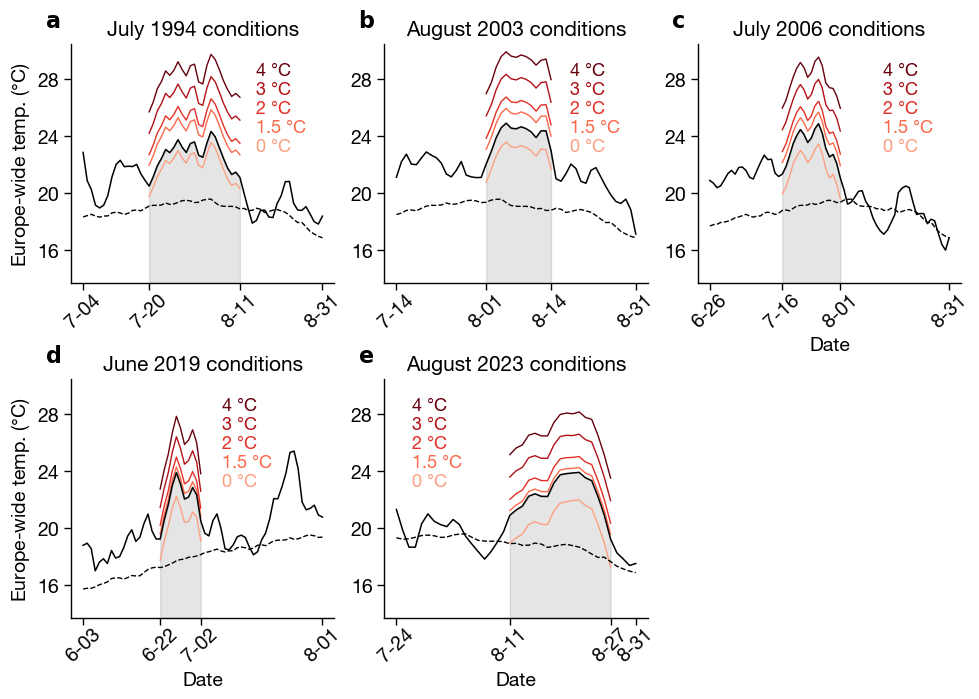

In [31]:
fig = plt.figure(figsize=(10,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"


tfs = 15
lbfs = 16
lbx = -0.1
lby = 1.07

gmts = [0,1.5,2,3,4]
cmap1 = plt.get_cmap('Reds')(np.linspace(0,1,int(len(gmts)*1.5)))
cmap = cmap1[(len(gmts)*-1):,:] #plt.get_cmap('Spectral_r')(np.linspace(0,1,len(gmts)*2))

gs0 = gridspec.GridSpec(2,3)
gs0.update(left=0.08,right=0.97,top=0.93,bottom=0.11,wspace=0.19,hspace=0.4)
lbs0 = [r"$\bf{a}$",r"$\bf{b}$",r"$\bf{c}$",r"$\bf{d}$",r"$\bf{e}$",]

# functions
wgted_mean_cf = lambda x: sum(x['population'] * x['tmcf']) / sum(x['population'])
wgted_mean_obs = lambda x: sum(x['population'] * x['tmobs']) / sum(x['population'])
wgted_mean_clm = lambda x: sum(x['population'] * x['tmclm_alldays']) / sum(x['population'])

# loop and plot
for j in np.arange(0,len(events),1):
    
    ### temps
    ax = plt.subplot(gs0[j])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ev = events[j]
    deaths_in = xr.open_dataset(loc_events+events[j]+"_tmean-interaction_counterfactual_mortality_noadaptation_noeventcf_europewide.nc")
    
    # limit to one week in on the front side
    # to make sure we have full weeks in the daily data
    wks = deaths_in.week.values[1:]
    wk1 = wks[0]
    wk2 = wks[-1]
    
    begin = pd.to_datetime(event_definitions.loc[event_definitions.event==ev,"begindate"].values[0])
    end = pd.to_datetime(event_definitions.loc[event_definitions.event==ev,"enddate"].values[0])
    
    cf_data = pd.read_csv(loc_events+ev+"_EOBSplusCNN_counterfactual_nuts3_daily_tmean.csv",index_col=0)
    cf_data_tm = cf_data.copy()
    cf_data_tm.loc[:,"week"] = pd.to_datetime(cf_data_tm.time.values).isocalendar().week.values.astype(int)
    cf_data_tm_wk = cf_data_tm.loc[(cf_data_tm.week>=wk1)&(cf_data_tm.week<=wk2),:]
    cf_data_tm_pop = pd.merge(cf_data_tm_wk,weekly_pop_mean,how="left",on="NUTS_ID")
    cf_data_tm_pop["month"] = pd.to_datetime(cf_data_tm_pop.time).dt.month
    del([cf_data])
    cf_data_nuts = cf_data_tm_pop.loc[(cf_data_tm_pop.month<=8),:].dropna(axis=0,subset="rate").rename(columns={"NUTS_ID":"nuts"})
    cf_data_mean = cf_data_nuts.groupby(["time","week","gmt"]).apply(wgted_mean_cf,include_groups=False).reset_index().rename(columns={0:"tmcf"})
    cf_data_mean_obs = cf_data_nuts.groupby(["time","week","gmt"]).apply(wgted_mean_obs,include_groups=False).reset_index().rename(columns={0:"tmobs"})
    cf_data_mean_clm = cf_data_nuts.groupby(["time","week","gmt"]).apply(wgted_mean_clm,include_groups=False).reset_index().rename(columns={0:"tmclm"})
    x_axis1 = [cf_data_nuts.time.values[0],begin,end,cf_data_nuts.time.values[-1]]
    x_axis = [str(z)[5:10] for z in x_axis1]
    del(cf_data_nuts)

    # obs 
    cf_data_obs = cf_data_mean_obs.loc[cf_data_mean_obs.gmt==0,:]
    x = [z[5:] for z in cf_data_obs.time]
    yobs = cf_data_obs.tmobs
    
    plt.plot(x,yobs,color="black",linewidth=1.1,zorder=3)
    cf_data_obs_event = cf_data_mean_obs.loc[(cf_data_mean_obs.time>=str(begin)[:10])&(cf_data_mean_obs.time<=str(end)[:10])&(cf_data_mean_obs.gmt==0),:]
    x_event = [z[5:] for z in cf_data_obs_event.time]
    ax.fill_between(x_event,12,cf_data_obs_event.tmobs.values,color="black",alpha=0.1)

    # climatology
    cf_data_clm = cf_data_mean_clm.loc[cf_data_mean_clm.gmt==0,:]
    xclm = [z[5:] for z in cf_data_clm.time]
    yclm = cf_data_clm.tmclm
    plt.plot(xclm,yclm,color="black",linewidth=1,zorder=3,linestyle="--")
    

    
    # each gmt
    for g in gmts:
        cf_data_g = cf_data_mean.loc[(cf_data_mean.gmt==g),:]
        tmg = pd.to_datetime(cf_data_g.time.values)
        ind = np.array([(x>=pd.to_datetime(begin))&(x<=pd.to_datetime(end)) for x in tmg])
        xg = [z[5:] for z in cf_data_g.time] #np.arange(1,len(cf_data_g.time)+1,1)
        yg = cf_data_g.tmcf
        col = cmap[gmts.index(g)]
        plt.plot(np.array(xg)[ind],yg[ind],color=col,linewidth=1,zorder=2)
        if ev=="june_2019":
            plt.text(0.57,0.55+(0.08*gmts.index(g)),str(g)+r" $\degree$C",
                    fontsize=13,color=col,transform=ax.transAxes)
        elif ev=="august_2023":
            plt.text(0.1,0.55+(0.08*gmts.index(g)),str(g)+r" $\degree$C",
                    fontsize=13,color=col,transform=ax.transAxes)
        else:
            plt.text(0.7,0.55+(0.08*gmts.index(g)),str(g)+r" $\degree$C",
                    fontsize=13,color=col,transform=ax.transAxes)
        
    
    plt.xticks(ticks=x_axis,labels=[str(x)[1:] for x in x_axis])    
    
    plt.ylim([13.7,30.5])
    #plt.yticks([14,18,22,26,30])
    plt.yticks([16,20,24,28])
    if (j == 0)|(j==3):
        plt.ylabel(r"Europe-wide temp. ($\degree$C)")
    plt.xticks(rotation=43,ha="center")#,rotation_mode="anchor")
    ax.tick_params(axis='x', which='major', pad=0)
    if j >= 2:
        plt.xlabel("Date")

    plt.text(lbx,lby,lbs0[j],fontsize=lbfs,transform=ax.transAxes)
    plt.title(names[j]+" conditions",fontsize=tfs)


plt.savefig(loc_figs+"FigX_Temperature_Timeseries_Predictions.pdf")
plt.show()

Adaptation when simply scaled by GMT change not local pattern scaling

In [14]:
events = ["july_1994","august_2003","july_2006","june_2019","august_2023"]
gmt_plot = 3
for j in np.arange(0,len(events),1):
    ev = events[j]
    deaths_noadapt = xr.open_dataset(loc_events+ev+"_tmean-interaction_counterfactual_mortality_noadaptation_noeventcf_europewide.nc")
    deaths_adapt = xr.open_dataset(loc_events+ev+"_tmean-interaction_counterfactual_mortality_gmtadaptation_noeventcf_europewide.nc")
    deaths_noadapt_g = deaths_noadapt.deaths.loc[:,gmt_plot,:]
    deaths_adapt_g = deaths_adapt.deaths.loc[:,gmt_plot,:]
    if j == 0:
        deaths_noadapt_all = deaths_noadapt_g.expand_dims("event")
        deaths_adapt_all = deaths_adapt_g.expand_dims("event")
    else:
        deaths_noadapt_all = xr.concat([deaths_noadapt_all,deaths_noadapt_g],dim="event")
        deaths_adapt_all = xr.concat([deaths_adapt_all,deaths_adapt_g],dim="event")
deaths_noadapt_all.coords["event"] = events
deaths_adapt_all.coords["event"] = events

-0.12508475666426905


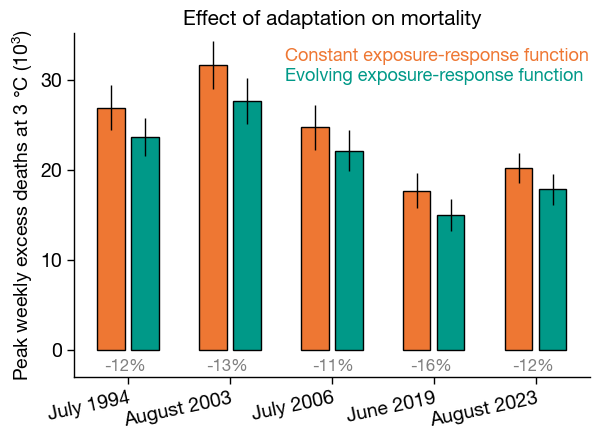

In [16]:
fig = plt.figure(figsize=(6,4.3))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

## bar plots by event

gs0 = gridspec.GridSpec(1,1)
gs0.update(left=0.12,right=0.98,top=0.92,bottom=0.12,wspace=0.2,hspace=0.2)

tfs = 15
lbfs = 19
lbx = -0.1
lby = 1.06

ax = plt.subplot(gs0[0,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#ax.spines["left"].set_visible(False)

noadapt_col = "#EE7733"
adapt_col = "#009988"

x1 = [0,3,6,9,12]
x2 = [1,4,7,10,13]
tks = [0.5,3.5,6.5,9.5,12.5]

d1 = deaths_noadapt_all.mean(dim="sample").max(dim="week")
d2 = deaths_adapt_all.mean(dim="sample").max(dim="week")
difference = (d2-d1)/d1


plt.bar(x=x1,height=deaths_noadapt_all.mean(dim="sample").max(dim="week")/1000.0,
        edgecolor="black",facecolor=noadapt_col,
       yerr=1.96*deaths_noadapt_all.max(dim="week").std(dim="sample")/1000.0,
       error_kw={"lw":1})
plt.bar(x=x2,height=deaths_adapt_all.mean(dim="sample").max(dim="week")/1000.0,
        edgecolor="black",facecolor=adapt_col,error_kw={"lw":1},
        yerr=1.96*deaths_adapt_all.max(dim="week").std(dim="sample")/1000.0)

#plt.axhline(y=0,color="gray",linestyle="--")
names = [x.split("_")[0].title()+" "+x.split("_")[1] for x in events]
plt.xticks(ticks=tks,labels=names,rotation=12,ha="right",rotation_mode="anchor")
plt.ylim([-3,35.2])
plt.yticks([0,10,20,30])
plt.ylabel(r"Peak weekly excess deaths at 3 $\degree$C (10$^3$)")

plt.text(0.41,0.92,"Constant exposure-response function",color=noadapt_col,fontsize=13,
         transform=ax.transAxes)
plt.text(0.41,0.86,"Evolving exposure-response function",color=adapt_col,fontsize=13,
         transform=ax.transAxes)
plt.title("Effect of adaptation on mortality",fontsize=tfs)

for j in np.arange(0,len(events),1):
    if events[j]=="july_2006":
        xminus = 0.08
    else:
        xminus = 0.2
    plt.text(x1[j]-xminus,-2.3,str(int(np.around(difference.values[j]*100)))+"%",
             fontsize=12,color="gray")
print(difference.mean().values)

plt.savefig(loc_figs+"FigX_GMT_Adaptation.pdf")
plt.show()

Deltas by each region for each event

In [48]:
region_means = pd.read_csv(loc_events+"events_EOBSplusCNN_IPCCregion_mean_temperature.csv",index_col=0)

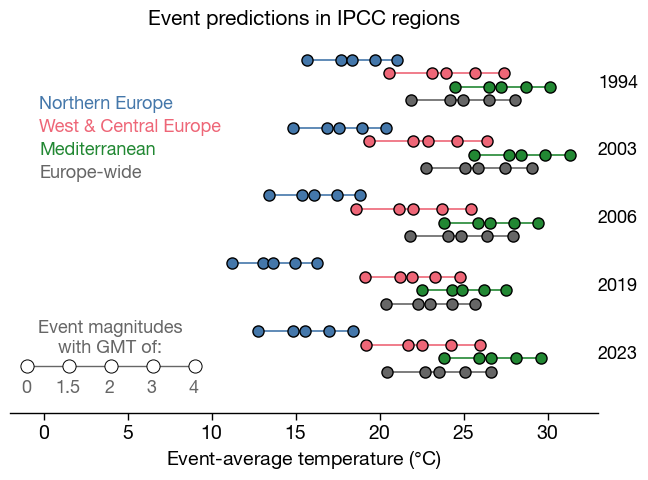

In [49]:
fig = plt.figure(figsize=(7,5))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

tfs = 15
lbfs = 19
lbx = -0.1
lby = 1.06
gmts = [0,1.5,2,3,4]
#cmap1 = plt.get_cmap('Reds')(np.linspace(0,1,int(len(gmts)*1.5)))
#cmap = cmap1[(len(gmts)*-1):,:] #plt.get_cmap('Spectral_r')(np.linspace(0,1,len(gmts)*2))
gmt_gray_color = plt.get_cmap('Greys')(np.linspace(0,1,int(len(gmts)*1.8)))

# other colors
neu_col = "#4477AA"
med_col = "#228833"
wce_col = "#EE6677"
eu_col = [0.4,0.4,0.4]


## maps
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.06,right=0.9,top=0.9,bottom=0.14,wspace=0.03,hspace=0.04)

ax = plt.subplot(gs1[0,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

yvals = np.array([[25,24,23,22],
                [20,19,18,17],
                [15,14,13,12],
                [10,9,8,7],
                 [5,4,3,2]])

regions = ["NEU","WCE","MED"]
for j in np.arange(0,len(events),1):
    ev = events[j]
    for rr in np.arange(0,len(regions),1):
        r = regions[rr]
        ev_r = region_means.loc[(region_means.event==ev)&(region_means.region==r),:]
        if r == "NEU":
            col = neu_col
        elif r=="WCE":
            col = wce_col
        elif r=="MED":
            col = med_col
        plt.plot(ev_r.tm.values,[yvals[j,rr]]*5,markerfacecolor=col,color=col,
                 markeredgecolor="black",linewidth=1.2,markersize=8,marker="o")
    plt.plot(ev_cf.loc[ev,:].values,[yvals[j,3]]*5,markerfacecolor=eu_col,
            color=eu_col,markeredgecolor="black",linewidth=1.2,markersize=8,marker="o")
    
    yr = str(ev.split("_")[1])
    plt.text(33,yvals[j,2],yr,fontsize=13,color="black")


plt.xlim([-2,33])
#plt.ylim([-3,10])
plt.ylim([-1,27])
plt.xlabel(r"Event-average temperature ($\degree$C)")


# legend thing for the dots
textcol = [0.4,0.4,0.4]
plt.text(0.17,0.16,"Event magnitudes"+"\n"+"with GMT of:",
         fontsize=13,rotation=0,ha="center",transform=ax.transAxes,
        color=textcol)
plt.plot([-1,1.5,4,6.5,9],[2.4]*len(gmts),color=[0.4,0.4,0.4],linewidth=1,zorder=3)
plt.scatter([-1,1.5,4,6.5,9],[2.4]*len(gmts),s=90,
         facecolor="white",edgecolor="black",zorder=4,linewidth=0.7)
for gg in np.arange(0,len(gmts),1):
    g = gmts[gg]
    x = -3.55+(2.5*(gg+1))
    if g==1.5:
        strg = str(g)
    else:
        strg = str(int(g))
    plt.text(x,0.5,strg,fontsize=13,color=textcol,ha="center")

plt.text(0.05,0.62,"Europe-wide",fontsize=13,color=eu_col,
         transform=ax.transAxes)
plt.text(0.05,0.8,"Northern Europe",fontsize=13,color=neu_col,
         transform=ax.transAxes)
plt.text(0.05,0.74,"West & Central Europe",fontsize=13,color=wce_col,
         transform=ax.transAxes)
plt.text(0.05,0.68,"Mediterranean",fontsize=13,color=med_col,
         transform=ax.transAxes)

plt.yticks([])
ax.spines["left"].set_visible(False)

plt.title("Event predictions in IPCC regions",fontsize=tfs)


plt.savefig(loc_figs+"FigX_IPCCRegion_Event_Means.pdf")
plt.show()